### Generate input data

<IPython.core.display.Javascript object>


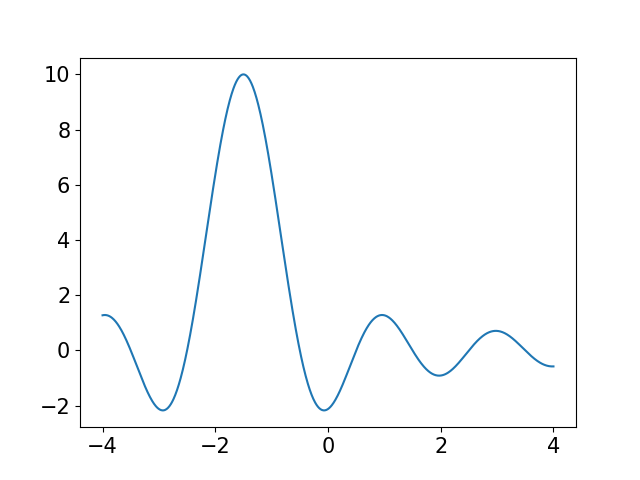

In [66]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.ndimage import zoom
from tqdm import tqdm

def addNoise(y, sigma=0.1):
    return y+sigma*np.random.normal(size=y.size)

# --- set problem input parameters here ---
Dmin           = -4.
Dmax           = 4.
nSincPoints    = 1000
scale          = 10
sincFunc       = True
# ------------------------------------------

if sincFunc:
    x = np.linspace(Dmin, Dmax, nSincPoints)
    y = scale * np.sinc(x+1.5)
else:
    y = np.fromfile("/home/ynashed/workspace/mfa/wiki/yn_python_testbed/s3d.raw", dtype=np.float64) #

nPoints = y.shape[0]
x = np.linspace(Dmin, Dmax, nPoints)
#y = addNoise(y, 0.1)
yRange = y.max()-y.min()
plt.figure()
plt.plot(x, y)

### LSQ B-spline approximation (scipy.interpolate.LSQUnivariateSpline)

<IPython.core.display.Javascript object>


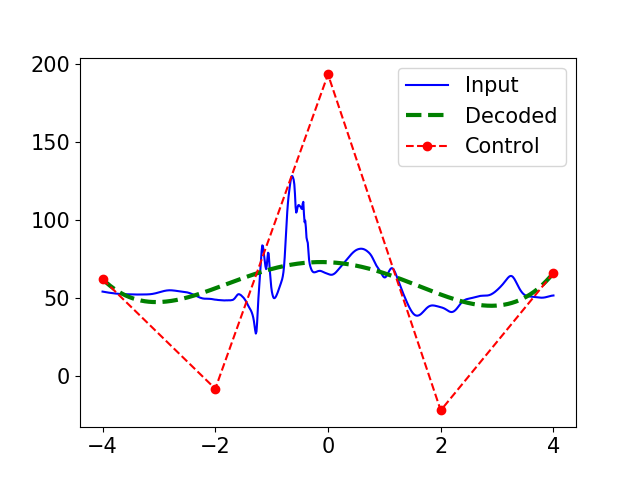

Sum of squared residuals of the spline approximation 114664.906444


In [17]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
import collections

degree             = 4
nControlPoints     = degree + 1 #minimum number of control points
nControlPointSpans = nControlPoints - 1


def getControlPoints(knots, k):
    if not isinstance(k, collections.Iterable):
        nCtrlPts = len(knots) - 1 - k
        cx       = np.zeros(nCtrlPts)
        for i in range(nCtrlPts):
            tsum = 0
            for j in range(1, k + 1):
                tsum += knots[i + j]
            cx[i] = float(tsum) / k
        return cx
    else:
        cx = []
        for di,deg in enumerate(k):
            ti_1 = knots[di-1] if di>0 else 0
            ti  = knots[di]
            cx += list(getControlPoints(np.concatenate(([ti_1]*(deg+1), [ti]*(deg+1))), deg))
        cx = np.array(cx)
        return np.unique(cx.round(decimals=4))

nInternalKnotSpans = nControlPointSpans - degree + 1

inc = 1. / nInternalKnotSpans
t   = np.linspace(inc, 1-inc, nInternalKnotSpans - 1)
U   = np.linspace(0, 1, nPoints)
knots    = np.concatenate(([0] * (degree+1), t, [1] * (degree+1)))

# print "nInternalKnotSpans: ", nInternalKnotSpans
# print "inc: ", inc
# print "t: ", t
plt.figure()
plt.plot(x, y, 'b-', ms=5, label='Input')

spl = LSQUnivariateSpline(U, y, t, k=degree)
plt.plot(x, spl(U), 'g--', lw=3, label='Decoded')

# get the control points (not sure if these are right)
knots    = spl.get_knots()
knots    = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))
P        = spl.get_coeffs()
coeffs_x = getControlPoints(knots, degree) * (Dmax - Dmin) + Dmin
plt.plot(coeffs_x, P, marker='o', linestyle='--', color='r', label='Control')

plt.legend()
plt.show()

# print "Knots: ", knots
# print "Normalized knots:", (knots - Dmin) / (Dmax - Dmin)
# print "Control point x:", coeffs_x
# print "Control point y:", P
print "Sum of squared residuals of the spline approximation", spl.get_residual()

def scaleInputs(scaleFactor=1.0, noise=0.0, compression=100):
    global y, nPoints, x, yRange, nControlPoints, U, knots
    
    if sincFunc:
        x = np.linspace(Dmin, Dmax, nSincPoints)
        y = scale * np.sinc(x+1.5)
    else:
        y = np.fromfile("s3d.raw", dtype=np.float64)
        
    y = zoom(y, scaleFactor, order=4)
    nPoints = y.shape[0]
    x = np.linspace(Dmin, Dmax, nPoints)
    y = addNoise(y, noise)
    yRange = y.max()-y.min()
    nControlPoints = 50#max(nPoints/compression, degree+1)
    nControlPointSpans = nControlPoints - 1
    nInternalKnotSpans = nControlPointSpans - degree + 1

    inc = 1. / nInternalKnotSpans
    t   = np.linspace(inc, 1-inc, nInternalKnotSpans - 1)
    U   = np.linspace(0, 1, nPoints)
    knots    = np.concatenate(([0] * (degree+1), t, [1] * (degree+1)))
    print "Inputs scaled to :", y.shape, "CtrlPts:", nControlPoints

### Solve for P using scipy.linalg.lstsq

In [10]:
from scipy.optimize import minimize, linprog, LinearConstraint
from quadprog import solve_qp
from scipy import linalg

EPS    = 1e-32
GTOL   = 1e-2
basis  = lambda u,p,T: ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else \
                    ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * basis(u,p-1,T)[:-1] + \
                    ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * basis(u,p-1,T)[1:]
        
def decode(P, W, x, T, degree):
    if not isinstance(degree, collections.Iterable):
        return np.array([(np.sum(basis(x[u],degree,T) *P*W)/(np.sum(basis(x[u],degree,T)*W))) for u,_ in enumerate(x)])
    else:
        y = np.zeros_like(x)
        si = 0
        for ti,t in enumerate(T):
            span = np.all((U>=(T[ti-1] if ti>0 else 0), U<=t), axis=0) 
            u = U[span]
            deg = degree[ti]
            p = P[si:si+deg+1]
            w = W[si:si+deg+1]
            si += deg
            t = np.concatenate(([0]*(deg+1), [1]*(deg+1)))
            y[span] = decode(p, w, np.linspace(0,1,u.shape[0]), t, deg)
        return y

def Error(P, W, y, x, t, degree):
    return decode(P, W, x, t, degree) - y

def lsqFitWithCons(N, W, y, U, t, degree, cons=None, continuity=0):
    def l2(P, W, y, U, t, degree):
        return np.sum(Error(P, W, y, U, t, degree)**2)
    res = minimize(l2, np.ones_like(W), method='SLSQP', args=(W, y, U, t, degree), 
                   constraints=cons,  options={'disp': True})
    return res.x

def lsqFit(N, W, y, U, t, degree, constraints=None, continuity=0):
    if constraints is None or len(constraints)==0:
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        LHS = np.matmul(RN.T,RN)
        RHS = np.matmul(RN.T, y)
        return linalg.lstsq(LHS, RHS)[0]
    else:
        return lsqFitWithCons(N, W, y, U, t, degree, cons=constraints, continuity=0)

def SSE(W, P, t, y, U, degree=degree):
    return np.sum(Error(P, W, y, U, t, degree)**2)

def NMaxError(P, W, y, U, T, degree=degree):
    E = Error(P, W, y, U, T, degree)
    return np.abs(E).max()/yRange

def NMSE(P, W, y, U, T, degree=degree):
    return (Error(P, W, y, U, T, degree)**2).mean()/yRange

def MaKruth95(y, N):
    Nt  = N.T
    NtN  = np.matmul(Nt,N)
    NtNi = linalg.inv(NtN)
    NtQN = np.matmul(np.matmul(Nt, np.diag(y)), N)
    NtQ2N= np.matmul(np.matmul(Nt, np.diag(y**2)), N)
    
    M = NtQ2N - np.matmul(np.matmul(NtQN,NtNi),NtQN)
    Mcond = np.linalg.cond(M)
    w, v = linalg.eigh(M)
#     return v[:,0], Mcond

    if np.all(v[:,0] > 0):
        return v[:,0], Mcond
    elif np.all(v[:,0] < 0):
        return -v[:,0], Mcond
    else:
        w0 = v[:,0].copy()
        for i in xrange(1,v.shape[1]):
            V = v[:,:i+1]
            #V[abs(V)<1e-12] = 0
            A = abs(V)
            c = A.shape[0]
            ub = np.ones(c)*1e4
            A = np.vstack((A, -A))
            ub = np.vstack((ub, -np.ones(c)))
            
            res = linprog(np.ones(A.shape[1]), A_ub=A, b_ub=ub, options={"maxiter": 10})
            if res.success:
                W = np.matmul(V, res.x)
                if np.all(W > 0):
                    print "Successful linear programming solve from", i+1, "eigenvectors"
                    return W, Mcond
    print "Failed to find a solution to the linear programming problem combining eigenvectors"
    return np.ones(M.shape[0]), Mcond

# scaleInputs()

N = basis(U[np.newaxis,:],degree,knots[:,np.newaxis]).T
W = np.ones(nControlPoints)
popt = lsqFit(N, W, y, U, knots, degree)
print SSE(W, popt, knots, y, U, degree)
print NMaxError(popt, W, y, U, knots, degree)

W, Mcond = MaKruth95(y, N)
popt = lsqFit(N, W, y, U, knots, degree)
print "Ma&Kruth Weights:", W
print "M matrix condition number:", Mcond
print SSE(W, popt, knots, y, U, degree)
print NMaxError(popt, W, y, U, knots, degree)

7413.292298508522
0.5044981270001575
Failed to find a solution to the linear programming problem combining eigenvectors
Ma&Kruth Weights: [1. 1. 1. 1. 1.]
M matrix condition number: 1614.4180747169464
7413.292298508522
0.5044981270001575


### Hybrid Approach (Solve for P usign LSQ, and W using derivative from Xie'12)

<IPython.core.display.Javascript object>


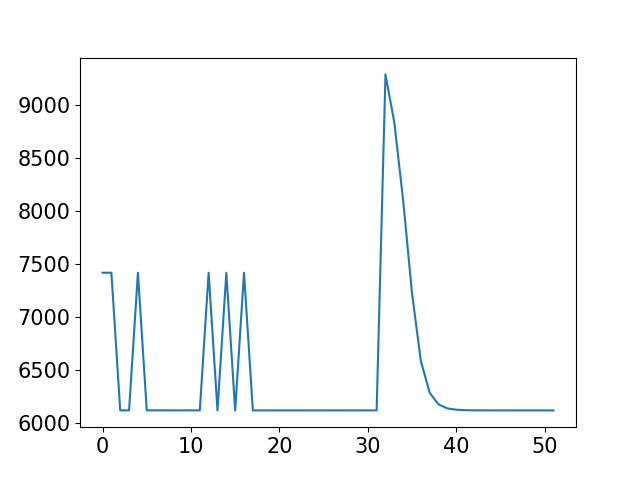

Ctrl points #: 5
Sum of squared error: 6471.749839069336
Normalized max error: 0.48747604936256067


<IPython.core.display.Javascript object>


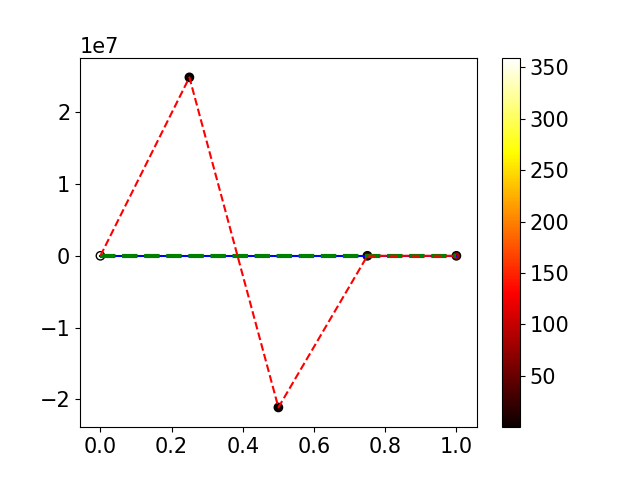

In [11]:
def SSE_LSQ(W, params, constraints):
    if params.get('fixW',None) is not None:
        W = np.pad(W, params['fixW'], mode='constant', constant_values=1.)
    params['P'] = lsqFit(params['N'], W, params['y'], params['U'], params['T'], params['degree'], constraints=constraints)
    params['EList'].append(SSE(W, params['P'], params['T'], params['y'], params['U'], params['degree']))
#     print "Loss :", params['EList'][-1]
#     clear_output(wait=True)
    return params['EList'][-1]

def XieOptW(w0, params, optimizer='BFGS', der=None, bnds=None, constraints=None):
    if params.get('fixW',None) is not None:
        w0 = w0[ params['fixW'][0]: -params['fixW'][1] if params['fixW'][1]>0 else len(w0)]
        if bnds is not None:
            bnds = bnds[ params['fixW'][0]: -params['fixW'][1] if params['fixW'][1]>0 else len(bnds)]
    cons = []
    if constraints is not None:
        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([x[0]- constraints[1][-1]])} )
            
    res = minimize(SSE_LSQ, w0, args=(params, constraints),\
                   method=optimizer, jac=der, bounds=bnds, constraints=cons)
    Wout = res.x
    if params.get('fixW',None) is not None:
        Wout = np.pad(Wout, params['fixW'], mode='constant', constant_values=1.)
    return Wout, res.nfev

def dNURBS_dW(W, P, N):
    swn = np.sum(N*W, axis=1)
    swdn = np.sum(N*W*P, axis=1)
    return np.asarray([ (N[:,i]*(P[i]*swn - swdn))/swn**2 for i,_ in enumerate(W)])
                 
def dE_dW(W, params, constraints):
    if params.get('fixW',None) is not None:
        W = np.pad(W, params['fixW'], mode='constant', constant_values=1.)
    B = Error(params['P'], W, params['y'], params['U'], params['T'], degree)
    dPdW = dNURBS_dW(W, params['P'], params['N'])
    dEdW = 2*np.matmul(dPdW, B)
    if params.get('fixW',None) is not None:
        dEdW = dEdW[ params['fixW'][0]: -params['fixW'][1] if params['fixW'][1]>0 else len(dEdW)]
    return dEdW

PH = popt.copy()
W0 = np.ones_like(PH)
T  = knots.copy()
N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
wbounds = [(1e-4,1e4) for _ in W0]

errorsHPD = [SSE(W0, PH, T, y, U, degree)]
optParams = {'P':PH, 'N':N, 'T':T, 'y':y, 'U':U, 'degree':degree, 'EList':errorsHPD}
W0,fev = XieOptW(W0, optParams, optimizer='L-BFGS-B', der=dE_dW, bnds=wbounds)
PH = optParams['P']

plt.figure()
errorsHPD  = np.asarray(errorsHPD)
plt.plot(errorsHPD)
plt.show()

print "Ctrl points #:", len(W0)
E = Error(PH, W0, y, U, T, degree)
print "Sum of squared error:", np.sum(E**2)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decode(PH, W0, U, T, degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(T, degree)
plt.plot(coeffs_x, PH, 'r--', label='Control')
plt.scatter(coeffs_x, PH, c=W0, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

### Solve for P and W using BFGS and AD gradient

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 4029.196777
  Number of iterations: 266
  Number of functions evaluations: 313


<IPython.core.display.Javascript object>


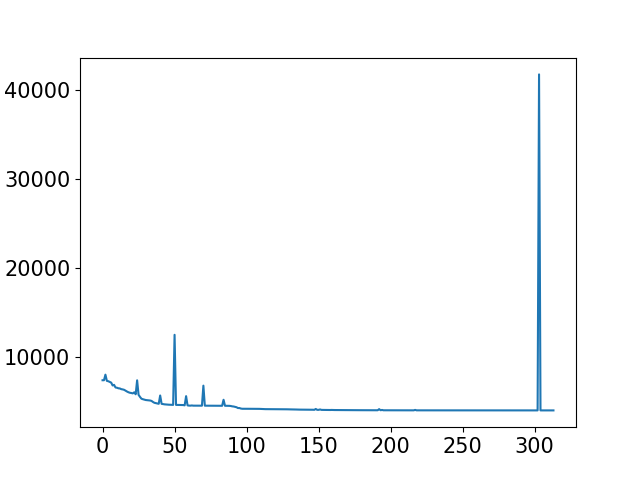

Ctrl points #: 5
Sum of squared error: 4029.197018393004
Normalized max error: 0.34868032668283844


<IPython.core.display.Javascript object>


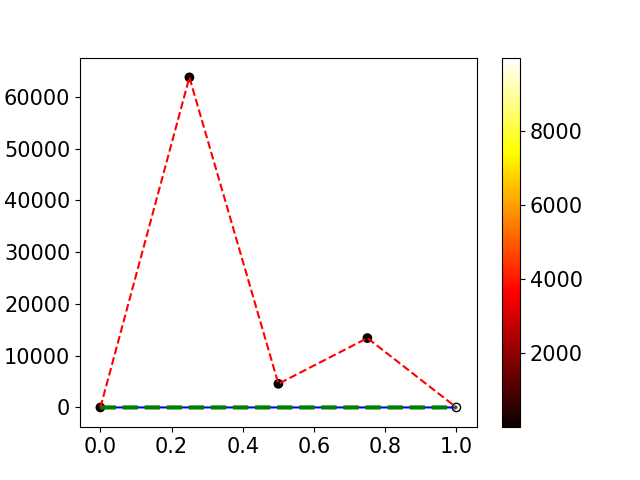

In [13]:
import tensorflow as tf

l1RegW = 0

def lossCallback(loss_evaled):
    global errorsWP
    errorsWP.append(loss_evaled)
    #print "Loss:", errorsWP[-1]
    #clear_output(wait=True)
    
def ADOptW(w0, params, solveW=True, optimizer='BFGS', 
           bnds=None, constraints=None, constraintRanges=[], continuity=0):
    global errorsWP
    errorsWP = []
    
    P_t = tf.Variable(params['P'], dtype=tf.float32, name="P")
    W_t = tf.Variable(w0, dtype=tf.float32, name="W") if solveW else \
          tf.constant(w0, dtype=tf.float32)
    Y_t = tf.constant(params['y'], dtype=tf.float32)

    with tf.name_scope("Basis"):
        X_t = tf.constant(params['U'][np.newaxis,:], dtype=tf.float32)
        knots_t = tf.constant(params['T'][:,np.newaxis], dtype=tf.float32)
        TFbasis = lambda u,p,T: tf.to_float(T[:-1]<=u) * tf.to_float(u<=T[1:]) if p==0 else \
                            ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * TFbasis(u,p-1,T)[:-1] + \
                            ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * TFbasis(u,p-1,T)[1:]
        N_t = tf.transpose(TFbasis(X_t,params['degree'],knots_t)) 
        #N_t = tf.constant(params['N'], dtype=tf.float32)
       
    with tf.name_scope("NURBS"):
        NURBS = tf.reduce_sum(N_t * P_t * W_t, axis=1) / tf.reduce_sum(N_t * W_t, axis=1)
    with tf.name_scope("Loss"):
        residual = Y_t-NURBS
        loss = tf.reduce_sum(tf.square(residual)) + l1RegW*tf.reduce_max(tf.abs(residual))
    
    equalities = []
    for CR in constraintRanges:
        for i in xrange(CR[0],CR[1]):
            equalities.append( P_t[i] - constraints[0][i] )
            if solveW:
                equalities.append( W_t[i] - constraints[1][i] )
        
    minBounds = [x[0] for x in bnds] if bnds is not None else -np.infty
    maxBounds = [x[1] for x in bnds] if bnds is not None else np.infty
    
    init_op = tf.global_variables_initializer()
    sess = tf.Session()
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, method=optimizer, 
                                                       equalities=equalities, 
                                                       var_to_bounds={W_t: (minBounds, maxBounds)})
    sess.run(init_op)
   
    optimizer.minimize(sess, loss_callback=lossCallback, fetches=[loss])
    params['P'] = sess.run(P_t)
    W = sess.run(W_t)
    decoded = sess.run(NURBS)
    sess.close()
    tf.reset_default_graph()
    
    params['EList'] += errorsWP
    return W, params['P'], decoded

PH = popt.copy()
W0 = np.ones_like(PH)
T  = knots.copy()
N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
errorsWP = [SSE(W0, PH, T, y, U, degree)]
optParams = {'P':PH, 'N':N, 'T':T, 'y':y, 'U':U, 'degree':degree, 'EList':errorsWP}
wbounds = [(1e-4,1e4) for _ in W0]
W0,PH,decoded = ADOptW(W0, optParams, optimizer='L-BFGS-B', bnds=wbounds)

plt.figure()
errorsWP  = np.asarray(optParams['EList'])
plt.plot(errorsWP)
plt.show()

print "Ctrl points #:", len(W0)
E = decoded-y
print "Sum of squared error:", np.sum(E**2)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decoded, 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(T, degree)
plt.plot(coeffs_x, PH, 'r--', label='Control')
plt.scatter(coeffs_x, PH, c=W0, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

#### Plot Comparison

<IPython.core.display.Javascript object>


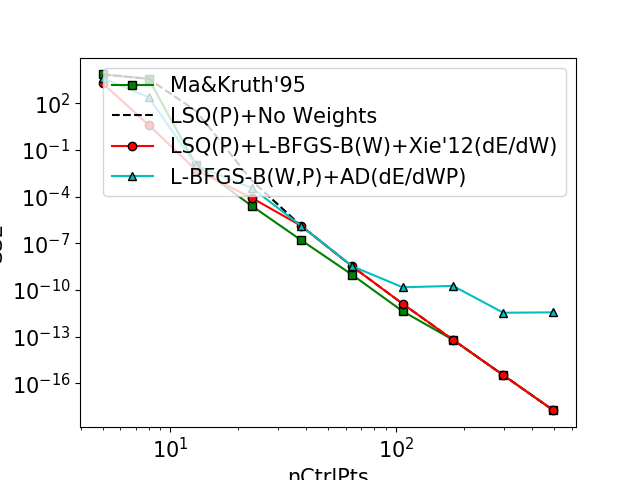

<IPython.core.display.Javascript object>


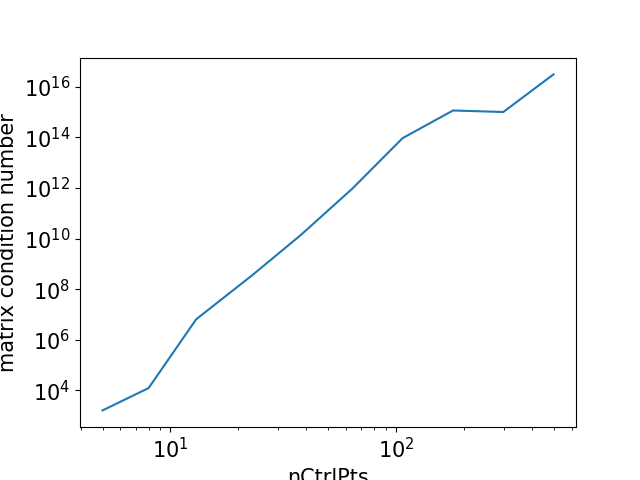

In [14]:
from scipy.interpolate import interp1d

def plotError(errorLine, c, l):
    xold = np.linspace(0, maxfev, errorLine.shape[0])
    xnew = np.arange(maxfev)
    fx = interp1d(xold, errorLine)
    plt.plot(xnew, fx(xnew), c, label=l)

nControl_min = degree + 1
nControl_max = nPoints/2
numRuns = 10
maxErrors = np.zeros( (numRuns,4) )
xAxis = np.geomspace(nControl_min, nControl_max, num=numRuns, dtype=int)
condNs = []

for ni,n in enumerate(xAxis):
    print "Fitting ctrl points #", n, float(ni+1)/numRuns
    nControlPointSpans = n - 1
    nInternalKnotSpans = nControlPointSpans - degree + 1
    inc = 1. / nInternalKnotSpans
    t   = np.linspace(inc, 1-inc, nInternalKnotSpans - 1)
    t   = np.concatenate(([0] * (degree+1), t, [1] * (degree+1)))
    u   = np.linspace(0, 1, nPoints)
    B   = basis(u[np.newaxis,:],degree,t[:,np.newaxis]).T
    W0  = np.ones(n)
    wbounds = [(1e-4,1) for _ in W0]
    
    P = lsqFit(B, W0, y, u, t, degree)
    maxErrors[ni,0] = SSE(W0, P, t, y, u, degree)

    errorsHPD = []
    optParams = {'P':P.copy(), 'N':B, 'T':t, 'y':y, 'U':u, 'degree':degree, 'EList':errorsHPD}    
    W,_ = XieOptW(W0, optParams, optimizer='L-BFGS-B', der=dE_dW, bnds=wbounds) 
    maxErrors[ni,1] = SSE(W, optParams['P'], t, y, u, degree)
    
    errorsWP = []
    optParams = {'P':P.copy(), 'N':B, 'T':t, 'y':y, 'U':u, 'degree':degree, 'EList':errorsWP}    
    W,_,_ = ADOptW(W0, optParams, optimizer='L-BFGS-B', bnds=wbounds)
    maxErrors[ni,2] = SSE(W, optParams['P'], t, y, u, degree)
    
    W, Mcond = MaKruth95(y, B)
    popt = lsqFit(B, W, y, u, t, degree)
    maxErrors[ni,3] = SSE(W, popt, t, y, u, degree)
    condNs.append(Mcond)
    
    clear_output(wait=True)

plt.figure()
plt.plot(xAxis, maxErrors[:,3], 'gs-', label='Ma&Kruth\'95', mec=(0,0,0,1))
plt.plot(xAxis, maxErrors[:,0], 'k--', label='LSQ(P)+No Weights')
plt.plot(xAxis, maxErrors[:,1], 'ro-', label='LSQ(P)+L-BFGS-B(W)+Xie\'12(dE/dW)', mec=(0,0,0,1))
plt.plot(xAxis, maxErrors[:,2], 'c^-', label='L-BFGS-B(W,P)+AD(dE/dWP)', mec=(0,0,0,1))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('SSE')
plt.xlabel('nCtrlPts')
plt.legend()

plt.figure()
plt.plot(xAxis, np.asarray(condNs), label='Ma&Kruth\'95-M')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('matrix condition number')
plt.xlabel('nCtrlPts')

# plt.figure()
# #plt.plot(errorsN, 'b-', label='AD(P,W)')
# #plt.plot(errorsH, 'g-', label='LSQ(P)+AD(W)')
# plt.plot(errorsHPD, 'r-', label='LSQ(P)+L-BFGS-B(W)+Xie\'12(dE/dW)')
# plt.plot(errorsWP, 'c-', label='L-BFGS-B(W,P)+AD(dE/dWP)')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel('SSE')
# plt.xlabel('iterations')

np.savetxt(("sinc" if sincFunc else "s3d")+("_%i_SSEvsN_deg%i.csv"%(nPoints,degree)), maxErrors, delimiter=',')

### Solve for W using Turner'08)

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import inv

K = nPoints/nControlPoints
Wmin = 0.1
Wmax = 1.0
C = 2.

p = np.log(np.log(C)) / np.log(1.0/nControlPoints)
theta = -np.log(Wmin)

def calcR(u1, xcp=None):
    return np.exp(-theta*(pairwise_distances(u1.reshape(-1,1), xcp, metric='l1')**p))


C = popt.copy()
WT = np.ones_like(C)
Px = getControlPoints(knots, degree)

nbrs = NearestNeighbors(n_neighbors=K, algorithm='brute').fit(U.reshape(-1,1))
distances, indices =  nbrs.kneighbors(Px.reshape(-1,1))

for i,ui in enumerate(indices):
    R = calcR(U[ui])
    r = calcR(U[ui], Px[i])
    WT[i] = Wmin + ((Wmax-Wmin)*np.matmul(np.matmul(r.T, inv(R)),r))
    

E = Error(C, WT, y, U, knots, degree)**2
print "Sum of squared error:", E.sum()
print "Max of squared error:", E.max()
print "Found Weights:", WT

Sum of squared error: 114061.13879885535
Max of squared error: 3404.0606573767213
Found Weights: [1.         0.62294158 0.60967566 0.62294158 1.        ]


### Adaptive fitting by splitting knot spans

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 113364.562500
  Number of iterations: 9
  Number of functions evaluations: 21
Iteration  0
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 84822.523438
  Number of iterations: 10
  Number of functions evaluations: 26
Iteration  1
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 69946.203125
  Number of iterations: 17
  Number of functions evaluations: 37
Iteration  2
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 40484.773438
  Number of iterations: 24
  Number of functions evaluations: 53
Iteration  3
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 9227.548828
  Number 

<IPython.core.display.Javascript object>


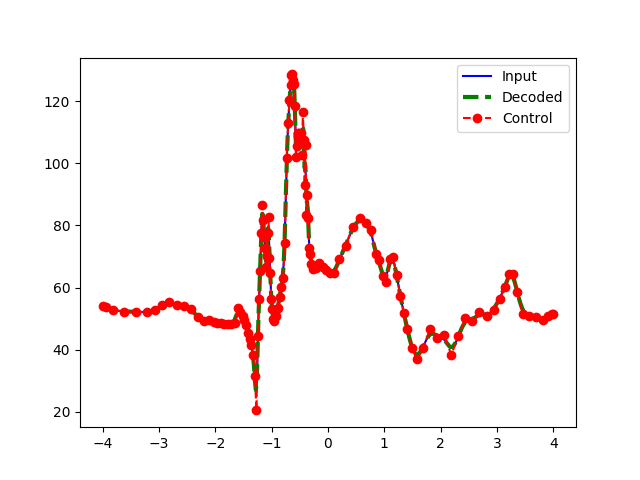

In [6]:
import collections

def rint(x):
    return int(round(x))

def toHomogeneous(P, W):
    return np.hstack( ( (P*W)[:,np.newaxis], W[:,np.newaxis]) )

def fromHomogeneous(PW):
    P = PW[:,0]
    W = PW[:,1]
    return P/W, W

def knotInsert(T, us, splitUs=True, r=1):
    if not isinstance(us, collections.Iterable):
        us = [us]
    Tnew = []
    toSplit = us
    if splitUs:
        t = T[degree:-degree]
        toSplit = np.unique(np.concatenate([ np.where(((t[:-1]<=u) * (u<=t[1:])).astype(np.float))[0] for u in us]).ravel())
        toSplit += degree
        for ti,tval in enumerate(T):
            Tnew.append(tval)
            if np.isin(ti, toSplit):
                for i in xrange(r):
                    Tnew.append(tval+((T[ti+1]-tval)/2.))
    else:
        Tnew = T.tolist()
        for u in us:
            for i in xrange(r):
                Tnew.append(u)
        Tnew = np.sort(Tnew)
    return np.array(Tnew), toSplit
               
def knotRefine(P, W, T,  r=1, decodedError=None, find_all=True, MAX_ERR = 1e-2):
    E = Error(P, W, y, U, T, degree) if decodedError is None else decodedError
    NSE = (E**2)/yRange
    NMSE = NSE.mean()
    if(NMSE<=MAX_ERR):
        return T, [], E
    us = U[np.where(NSE >=MAX_ERR)[0] if find_all else np.argmax(NSE)]
    Tnew,splitIndeces = knotInsert(T, us, r=r)
    return Tnew, splitIndeces, E

def deCasteljau(P, W, T, u, k, r=1):
    NP = len(P)
    Qnew = np.zeros( (NP+r, P.ndim+1) )
    Rw = np.zeros( (degree+1, P.ndim+1) )
    PW = toHomogeneous(P, W)

    mp = NP+degree+1
    nq = len(Qnew)

    Qnew[:k-degree+1] = PW[:k-degree+1]
    Qnew[k+r:NP+1+r] = PW[k:NP+1]
    Rw[:degree+1] = PW[k-degree:k+1]


    for j in range(1,r+1):
        L = k-degree+j
        for i in range(degree-j+1):
            alpha = (u-T[L+i])/(T[i+k+1]-T[L+i])
            Rw[i] = alpha*Rw[i+1] + (1.0-alpha)*Rw[i]

        Qnew[L] = Rw[0]
        Qnew[k+r-j] = Rw[degree-j]
        Qnew[L+1:k] = Rw[1:k-L]

    P,W = fromHomogeneous(Qnew)
    return P,W

def adaptive(P, W, T, strategy='reset', weighted=False, r=1, 
             MAX_ERR=1e-2, MAX_ITER=1000, split_all=True, decodedError=None):
    splitIndeces = []
    r = min(r,degree) #multiplicity can not be larger than degree
    
    for iteration in xrange(MAX_ITER):
        Tnew,splitIndeces,decodedError = knotRefine(P, W, T, r, decodedError=decodedError, 
                                                   MAX_ERR=MAX_ERR, find_all=split_all)
        if (len(T)==len(Tnew)):
            break
        
        if strategy == 'extend' and not split_all:   #only use when coupled with a solver
            k = splitIndeces[0]
            u = Tnew[k+1]
            P,W = deCasteljau(P, W, T, u, k, r)
        elif strategy == 'reset':
            N = basis(U[np.newaxis,:],degree,Tnew[:,np.newaxis]).T
            W = np.ones(len(Tnew) - 1 - degree)
            errorsHPD = []
#             P = lsqFit(N, W, y, U, T, degree)
            optParams   = {'P':W, 'N':N, 'T':Tnew, 'y':y, 'U':U, 'degree':degree, 'EList':errorsHPD}
            wbounds     = [(1e-1,1) for _ in W]
            W,P,decoded = ADOptW(W, optParams, solveW=weighted, optimizer='SLSQP', bnds=wbounds)
            decodedError = decoded-y
        else:
            print "Not Implemented!!"
        
        T = Tnew
        print "Iteration ", iteration
        
    return P, W, T, splitIndeces, decodedError

def XieKnotRefine(NT=1):   #there's still a bug here somewhere BEWARE
    T = np.zeros(nControlPoints+degree+1)
    kInternal = nControlPoints-degree
    for i in xrange(1,kInternal+1):
        ic = i * (float(nPoints)/(kInternal+1))
        for r in xrange(1,NT+1):
            T[degree+i] += (1.0/NT) * (U[rint(ic-r+1)] - ((1-ic+rint(ic))*(U[rint(ic)]-U[rint(ic-1)])))
    T[nControlPoints+1:] = 1
    return T
            
pAdaptive, WAdaptive, knotsAdaptive,k,decodedError = adaptive(popt, W, knots, 
                                                             MAX_ERR=1e-3, 
                                                             split_all=True)#, strategy='extend', r=2, MAX_ITER=5)
print "New ctrl points:", len(WAdaptive)
print "New knot vector:", knotsAdaptive
E2 = decodedError**2
print "Sum of squared error:", np.sum(E2)
print "Normalized mean squared error:", np.mean(E2/yRange)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(x, y, 'b-', ms=5, label='Input')
plt.plot(x, decodedError+y, 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
plt.plot(coeffs_x, pAdaptive, marker='o', linestyle='--', color='r', label='Control')

plt.legend()
plt.show()

## Global weight solve+Adaptive knot span splitting, iterative

INFO:tensorflow:Optimization terminated with:
  Message: Positive directional derivative for linesearch
  Objective function value: 85575.968750
  Number of iterations: 61
  Number of functions evaluations: 144
Iteration  0
INFO:tensorflow:Optimization terminated with:
  Message: Positive directional derivative for linesearch
  Objective function value: 71723.179688
  Number of iterations: 88
  Number of functions evaluations: 227
Iteration  1
INFO:tensorflow:Optimization terminated with:
  Message: Positive directional derivative for linesearch
  Objective function value: 54947.179688
  Number of iterations: 83
  Number of functions evaluations: 162
Iteration  2
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 23914.886719
  Number of iterations: 101
  Number of functions evaluations: 235
Iteration  3
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 4490.599121
  N

<IPython.core.display.Javascript object>


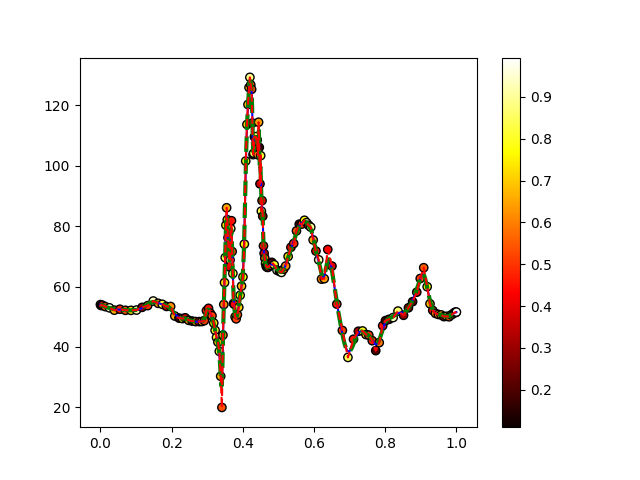

In [7]:
import timeit

def adaptiveFit(y, U, degree, weighted=True, splitAll=True, RMAX_ERR=1e-2,
                startParams=None):
    start_time = timeit.default_timer()
    order = degree+1
    T = np.concatenate(([0]*order, [1]*order)) if startParams is None else startParams['T']
    N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
    W0 = np.ones(order) if startParams is None else startParams['W']
    PH = lsqFit(N, W0, y, U, T, degree) if startParams is None else startParams['P']
    
    PH, W0, T, k, decodedE = adaptive(PH, W0, T, MAX_ERR=RMAX_ERR, strategy='reset', 
                                        split_all=splitAll, weighted=weighted)
    return T, PH, W0, len(PH), decodedE, (timeit.default_timer()-start_time) #fevals


Tnew, Plocal, Wlocal, nCtrlPts, decodedE, fevals = adaptiveFit(y, U, degree, 
                                                            weighted=True,
                                                            splitAll=True,
                                                            RMAX_ERR=1e-4)

print "fevals :", fevals
print "Ctrl points #:", nCtrlPts
E2 = decodedE**2
print "Sum of squared error:", np.sum(E2)
print "Normalized mean squared error:", np.mean(E2/yRange)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decodedE+y, 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(Tnew, degree)
plt.plot(coeffs_x, Plocal, 'r--', label='Control')
plt.scatter(coeffs_x, Plocal, c=Wlocal, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

# plt.figure()
# plt.plot(Elist)

## Local weight solve+Adaptive knot span splitting, iterative

Iteration  0
Max Error is at span: 4 (1,5)
Local solving (0,6)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Positive directional derivative for linesearch
  Objective function value: 84428.609375
  Number of iterations: 81
  Number of functions evaluations: 148
CtrlPts # 6 704 1.1861366106890265
Iteration  0
Max Error is at span: 4 (1,5)
Local solving (0,7)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 75339.242188
  Number of iterations: 33
  Number of functions evaluations: 97
CtrlPts # 7 704 1.0584401869946465
Iteration  0
Max Error is at span: 5 (2,6)
Local solving (0,8)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 68025.664062
  Number of iterations: 101
  Number of functions evaluations: 156
CtrlPts # 8 704 0.9556917048178604
Iteration  0
Max Error is at span: 6 (3,7)
Local solv

CtrlPts # 31 55 0.015826223148515912
Iteration  0
Max Error is at span: 19 (16,20)
Local solving (12,24)
Constrains (4,4)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 67.195801
  Number of iterations: 47
  Number of functions evaluations: 83
CtrlPts # 32 44 0.015624161943807386
Iteration  0
Max Error is at span: 8 (5,9)
Local solving (1,13)
Constrains (4,4)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 96.430267
  Number of iterations: 23
  Number of functions evaluations: 58
CtrlPts # 33 85 0.015135968604738726
Iteration  0
Max Error is at span: 32 (29,33)
Local solving (25,34)
Constrains (4,0)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 685.969788
  Number of iterations: 29
  Number of functions evaluations: 55
CtrlPts # 34 242 0.013206881901902863
Itera

CtrlPts # 57 154 0.0007322290986715337
Iteration  0
Max Error is at span: 37 (34,38)
Local solving (30,42)
Constrains (4,4)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 1.322268
  Number of iterations: 41
  Number of functions evaluations: 62
CtrlPts # 58 25 0.0007207336695037419
Iteration  0
Max Error is at span: 44 (41,45)
Local solving (37,49)
Constrains (4,4)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 9.387701
  Number of iterations: 15
  Number of functions evaluations: 39
CtrlPts # 59 132 0.0006753779621739305
Iteration  0
Max Error is at span: 43 (40,44)
Local solving (36,48)
Constrains (4,4)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 3.575532
  Number of iterations: 55
  Number of functions evaluations: 77
CtrlPts # 60 126 0.0006015710442814527

<IPython.core.display.Javascript object>


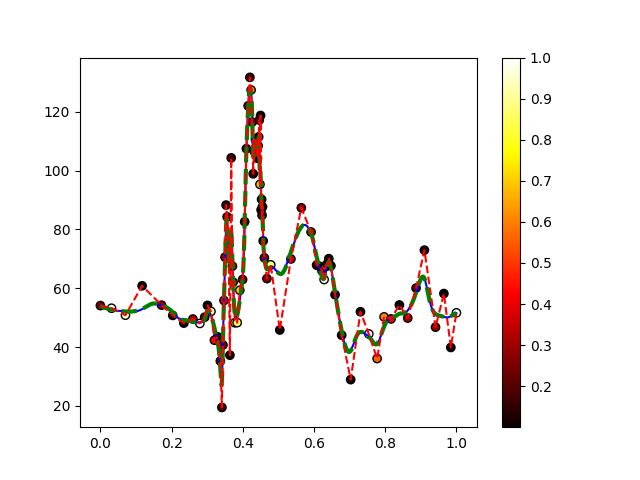

In [8]:
#%matplotlib inline
import timeit

def adaptiveFitLocal(y, U, degree, weighted=True, C=degree, RMAX_ERR=1e-2,
                    startParams=None):
    start_time = timeit.default_timer()
    order = degree+1
    T = np.concatenate(([0]*order, [1]*order)) if startParams is None else startParams['T']
    N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
    W0 = np.ones(order) if startParams is None else startParams['W']
    PH = lsqFit(N, W0, y, U, T, degree) if startParams is None else startParams['P']
    fevals = 0
    errorsHPD = []
    optParams = {'P':PH, 'N':N, 'T':T, 'y':y, 'U':U, 'degree':degree, 'EList':errorsHPD}
    decodedError = Error(PH, W0, y, U, T, degree)
    nmse = (decodedError**2).mean()/yRange
    while nmse>RMAX_ERR:
        PH, W0, T, ks, decodedError = adaptive(PH, W0, T, MAX_ERR=RMAX_ERR, 
                                        strategy='extend', MAX_ITER=1, 
                                        split_all=False, r=1                          
        N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
        for k in ks:
            optParams['EList'] = []
            addedPs = k-degree+1
            addedPe = k+1
            print "Max Error is at span:", k, "(%d,%d)"%(addedPs, addedPe)

            ps = max(addedPs-C,0)
            pe = min(addedPe+C,len(PH))
            print "Local solving (%d,%d)"%(ps,pe)

            CLeft  = 0 if addedPs<C else C
            CRight = 0 if pe-addedPe<C else C
            print "Constrains (%d,%d)"%(CLeft,CRight)

#             t = T[ps:pe+degree+1]
#             coeffs_x = getControlPoints(t, degree)
#             ui = np.all((U>=coeffs_x[0], U<=coeffs_x[-1]), axis=0)
            NTemp = N.copy()
            NTemp[:,:ps+CLeft] = 0
            NTemp[:,pe-CRight:] = 0
            ui = np.where(np.sum(NTemp, axis=1))[0]
            cropS = ui.min()
            cropE = ui.max()+1
            
            optParams['T'] = t
            optParams['U'] = U[ui]
            optParams['y'] = y[ui]
            optParams['N'] = N[cropS:cropE, ps:pe]
            optParams['P'] = PH[ps:pe]
            ww             = W0[ps:pe]
            wbounds        = [(1e-1,1) for _ in ww]
            cons           = [optParams['P'],ww]
            NP             = len(ww)
            W0[ps:pe],PH[ps:pe],decoded    = ADOptW(ww, optParams, solveW=weighted,
                                                    optimizer='SLSQP', bnds=wbounds,
                                                    constraintRanges=[(0,CLeft),
                                                                      (NP-CRight,NP)],
                                                    constraints=cons)
#             mask = optParams['N'].copy()
#             mask[:,:CLeft] = 0
#             mask[:,NP-CRight:] = 0
#             cui = np.where(np.sum(mask, axis=1))[0]
            
            decodedError[cropS:cropE] = decoded-y[ui]
            fevals   += len(optParams['EList'])*(len(optParams['P'])+len(optParams['y']))
        nmse = (decodedError**2).mean()/yRange
        print "CtrlPts #", len(PH), len(optParams['U']), nmse
        
    return T, PH, W0, len(PH), decodedError, (timeit.default_timer()-start_time) #fevals



Tnew, Plocal, Wlocal, nCtrlPts, decodedE, fevals = adaptiveFitLocal(y, U, degree, 
                                                                    weighted=True,
                                                                    C=degree, 
                                                                    RMAX_ERR=1e-4)

print "fevals :", fevals
print "Ctrl points #:", nCtrlPts
E2 = decodedE**2
print "Sum of squared error:", np.sum(E2)
print "Normalized mean squared error:", np.mean(E2/yRange)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decodedE+y, 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(Tnew, degree)
plt.plot(coeffs_x, Plocal, 'r--', label='Control')
plt.scatter(coeffs_x, Plocal, c=Wlocal, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

#### Plot Comparison

<IPython.core.display.Javascript object>


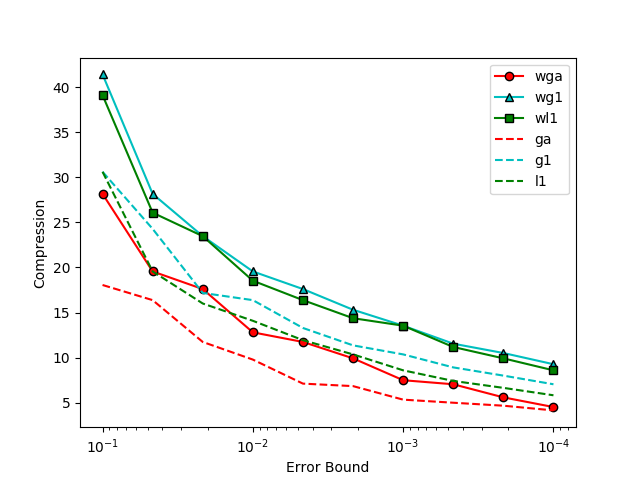

<IPython.core.display.Javascript object>


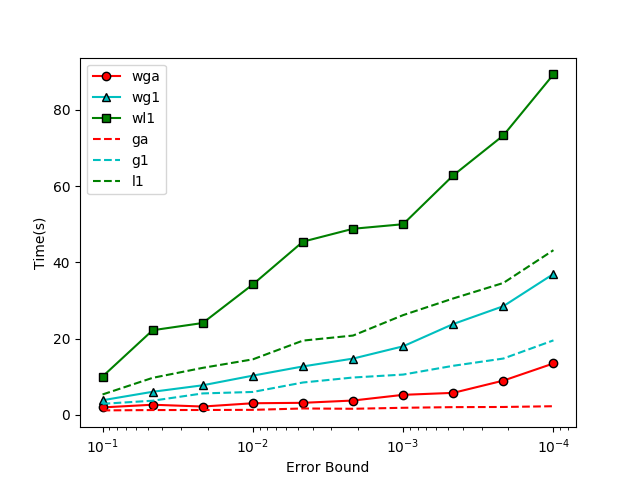

In [17]:
numRuns = 10
epsilon_max = 1e-1
epsilon_min = 1e-4
xAxis = np.geomspace(epsilon_max, epsilon_min, numRuns)
compressionFactors = np.zeros( (numRuns,6) )
cost = np.zeros( (numRuns,6) )

for ni,epsilon in enumerate(xAxis):
    degree = 4
    print "Solving for %e"%epsilon, float(ni+1)/numRuns
    
    ## Weighted ##
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,0] = adaptiveFit(y, U, degree, 
                                                             RMAX_ERR=epsilon,
                                                             weighted=True,
                                                             splitAll=True)
    compressionFactors[ni,0] = float(nPoints)/float(nCtrlPts)
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,1] = adaptiveFit(y, U, degree, 
                                                             RMAX_ERR=epsilon,
                                                             weighted=True,
                                                             splitAll=False)
    compressionFactors[ni,1] = float(nPoints)/float(nCtrlPts)
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,2] = adaptiveFitLocal(y, U, degree, 
                                                                  C=degree,
                                                                  weighted=True,
                                                                  RMAX_ERR=epsilon)
    compressionFactors[ni,2] = float(nPoints)/float(nCtrlPts)
    
    ## Unweighted ##
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,3] = adaptiveFit(y, U, degree, 
                                                             RMAX_ERR=epsilon,
                                                             weighted=False,
                                                             splitAll=True)
    compressionFactors[ni,3] = float(nPoints)/float(nCtrlPts)
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,4] = adaptiveFit(y, U, degree, 
                                                             RMAX_ERR=epsilon,
                                                             weighted=False,
                                                             splitAll=False)
    compressionFactors[ni,4] = float(nPoints)/float(nCtrlPts)
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,5] = adaptiveFitLocal(y, U, degree, 
                                                                  C=degree,
                                                                  weighted=False,
                                                                  RMAX_ERR=epsilon)
    compressionFactors[ni,5] = float(nPoints)/float(nCtrlPts)
    
    clear_output(wait=True)

    
plt.figure()
plt.plot(xAxis, compressionFactors[:,0], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,1], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,3], 'r--', label='ga', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,4], 'c--', label='g1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,5], 'g--', label='l1', mec=(0,0,0,1))
#plt.yscale('log')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.ylabel('Compression')
plt.xlabel('Error Bound')
plt.legend()

plt.figure()
plt.plot(xAxis, cost[:,0], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,1], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,3], 'r--', label='ga', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,4], 'c--', label='g1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,5], 'g--', label='l1', mec=(0,0,0,1))
#plt.yscale('log')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.ylabel('Time(s)')
plt.xlabel('Error Bound')
plt.legend()

np.savetxt(("sinc" if sincFunc else "s3d")+("_%i_nCtrlvsEps_deg%i.csv"%(nPoints,degree) ), compressionFactors, delimiter=',')
np.savetxt(("sinc" if sincFunc else "s3d")+("_%i_cost_deg%i.csv"%(nPoints,degree) ), cost, delimiter=',')

<IPython.core.display.Javascript object>


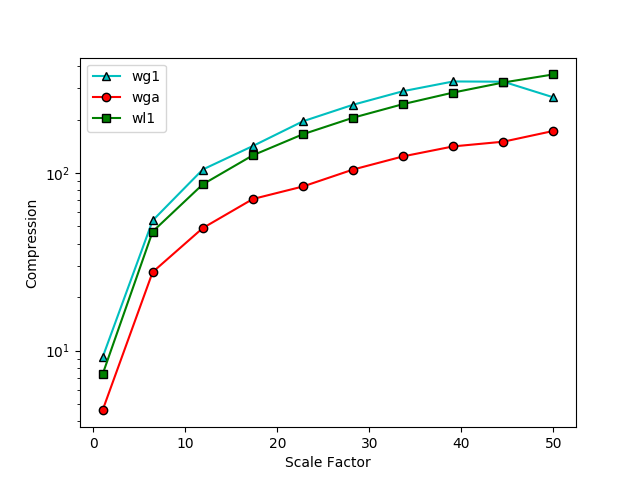

<IPython.core.display.Javascript object>


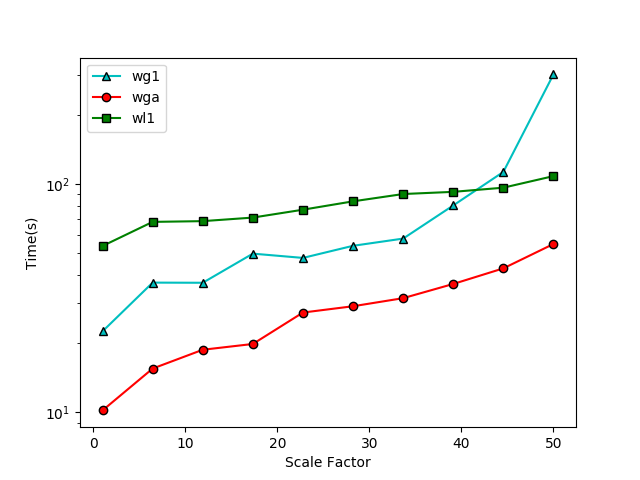

In [9]:
numMethods = 3
numRuns = 10
xAxis = np.linspace(1, 50, numRuns)

cost = np.zeros( (numRuns,numMethods) )
compressionFactors = np.zeros( (numRuns,numMethods) )

for ni,scale in enumerate(xAxis):
    degree = 4
    epsilon = 1e-4
    print "Run %d"%ni
    scaleInputs(scaleFactor=scale)
    N = basis(U[np.newaxis,:],degree,knots[:,np.newaxis]).T
    W = np.ones(nControlPoints)
    popt = lsqFit(N, W, y, U, knots, degree)
    startParams = {'P':popt, 'W':W, 'T':knots}
    ## Weighted ##
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,0] = adaptiveFit(y, U, degree, 
                                                             RMAX_ERR=epsilon,
                                                             weighted=True,
                                                             splitAll=False,
                                                             startParams=startParams)
    compressionFactors[ni,0] = float(nPoints)/float(nCtrlPts)
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,1] = adaptiveFit(y, U, degree, 
                                                             RMAX_ERR=epsilon,
                                                             weighted=True,
                                                             splitAll=True,
                                                             startParams=startParams)
    compressionFactors[ni,1] = float(nPoints)/float(nCtrlPts)
    #
    Tnew, Plocal, Wlocal, nCtrlPts,_, cost[ni,2] = adaptiveFitLocal(y, U, degree, 
                                                                  C=degree,
                                                                  weighted=True,
                                                                  RMAX_ERR=epsilon,
                                                                  startParams=startParams)
    compressionFactors[ni,2] = float(nPoints)/float(nCtrlPts)
    
    clear_output(wait=True)

plt.figure()
plt.plot(xAxis, compressionFactors[:,0], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,1], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Compression')
plt.xlabel('Scale Factor')
plt.legend()

plt.figure()
plt.plot(xAxis, cost[:,0], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,1], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Time(s)')
plt.xlabel('Scale Factor')
plt.legend()

np.savetxt(("sinc" if sincFunc else "s3d")+("_%i_nCtrlvsScale_deg%i.csv"%(nPoints,degree) ), compressionFactors, delimiter=',')
np.savetxt(("sinc" if sincFunc else "s3d")+("_%i_costvsScale_deg%i.csv"%(nPoints,degree) ), cost, delimiter=',')

## Bisecting method to find the maximum input interval that can be fit by a local p+1 ctrl points

INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 70.992767
  Number of iterations: 101
  Number of functions evaluations: 157
Span : 0 500 0.13544470094160732
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 74.032883
  Number of iterations: 86
  Number of functions evaluations: 129
Span : 0 480 0.06588929182286489
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 108.248245
  Number of iterations: 101
  Number of functions evaluations: 153
Span : 0 460 0.16200535485718942
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 80.203583
  Number of iterations: 47
  Number of functions evaluations: 87
Span : 0 440 0.15507239556536156
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective fu

<IPython.core.display.Javascript object>


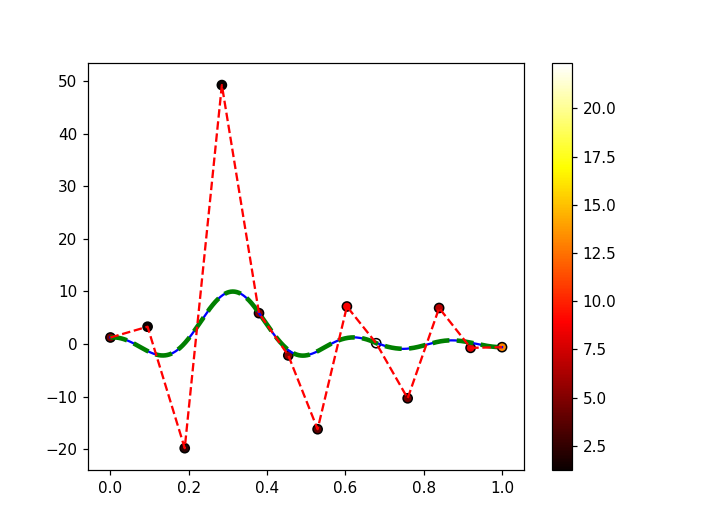

In [8]:
fitNURBS = True
errorsWP = []

def canFit(y, deg, weighted=False, firstSpan=False, prevP=None, prevW=None, continuity=0):  
    x = np.linspace(0,1,y.shape[0])
    T = np.concatenate(([0] * (deg+1), [1] * (deg+1)))
    nCtrlPts = len(T) - 1 - deg
    N = basis(x[np.newaxis,:],deg,T[:,np.newaxis]).T
    W = np.ones(nCtrlPts)
    cons=None if firstSpan else [prevP,prevW]
    P = lsqFit(N, W, y, x, T, deg)
    
    errorsHPD = []
    optParams = {'P':P, 'N':N, 'T':T, 'y':y, 'U':x, 'degree':deg, 'EList':errorsHPD}#, 'fixW':(int(not firstSpan), int(firstSpan))}
    wbounds   = [(1,1e4) for _ in W]
    NP  = len(prevP) 
    W,_ = ADOptW(W, optParams, solveW=weighted, optimizer='SLSQP', bnds=wbounds,
                 constraintRanges=[[(0,1),(NP-1,NP)]] if NP>0 else [],
                 constraints=cons, continuity=continuity)
    #XieOptW(W, optParams, optimizer='SLSQP', der=dE_dW, bnds=wbounds, constraints=cons)
    P   = optParams['P']
    fitError =  NMaxError(P, W, y, x, T, deg)
    return fitError, P, W, len(optParams['EList']) if NURB else 0

def bisectionFit(y, U, degree, rational=False, mult=degree, kmax=10, step=1, RMAX_ERR=1e-2, continuity=0):
    order = degree + 1
    ks = 0
    ke = min(y.shape[0], ks+kmax)
    T  = [0 for _ in range(order)]
    prevP = P = []
    prevW = W = []
    bezierSegments = 0
    fevals = 0
    while ks<y.shape[0]-1:
        rE,pp,ww,fev = canFit(y[ks:ke], degree, NURB=rational, firstSpan=(bezierSegments==0), \
                              prevP=prevP, prevW=prevW, continuity=continuity)
        fevals += fev*(order+len(y[ks:ke]))
        print "Span :", ks, ke, rE
        if rE > RMAX_ERR:
            assert (ke > ks+order), "Could not fit! Error bound too tight?"
            ke -= step
            ke = max(ks+order, ke)
        else:
            tval = (x[ke-1] - Dmin)/(Dmax - Dmin)
            print ks, ke, tval#, ww
            if bezierSegments>0:
                print "endpoints:", prevP[-1], pp[0], prevW[-1], ww[0]
            T  = np.concatenate((T, [tval]*mult) )
            for wi,wval in enumerate(ww):
                if wi==0 and len(W)>0:
                    continue
                W.append(wval)
                P.append(pp[wi])
            ks = ke-1
            ke = min(y.shape[0], ks+kmax)
            bezierSegments += 1
            prevP = pp.copy(); prevW = ww.copy()
            
    T  = np.concatenate((T, [1]*(order-mult)))
    nCtrlPts = len(T) - 1 - degree
    return np.array(T), np.array(P), np.array(W), degree, nCtrlPts, fevals

def bisectionFit2(y, U, deg, rational=False, mult=degree, kmax=10, 
                 step=1, RMAX_ERR=1e-2, continuity=0, degMin=1, degMax=10):
    ks = 0
    ke = min(y.shape[0], ks+kmax)
    prevP = P = []
    prevW = W = []
    T  = []
    degrees = []
    bezierSegments = 0
    fevals = 0
    
    while ks<y.shape[0]-1:
        for degree in xrange(degMin, degMax+1):
            order = degree + 1
            rE,pp,ww,fev = canFit(y[ks:ke], degree, NURB=rational, firstSpan=(bezierSegments==0), \
                                  prevP=prevP, prevW=prevW, continuity=continuity)
            fevals += fev*(order+len(y[ks:ke]))
            print "Span :", ks, ke, degree, rE
            if rE <= RMAX_ERR:
                break
        if rE > RMAX_ERR:
            assert (ke > ks+order), "Could not fit! Error bound too tight?"
            ke -= step
            ke = max(ks+order, ke)
        else:
            tval = (x[ke-1] - Dmin)/(Dmax - Dmin)
            print ks, ke, tval#, ww
            if bezierSegments>0:
                print "endpoints:", prevP[-1], pp[0], prevW[-1], ww[0]
            T.append(tval)
            for wi,wval in enumerate(ww):
                if wi==0 and len(W)>0:
                    continue
                W.append(wval)
                P.append(pp[wi])
            ks = ke-1
            ke = min(y.shape[0], ks+kmax)
            bezierSegments += 1
            prevP = pp.copy(); prevW = ww.copy()
            degrees.append(degree)
            
    nCtrlPts = len(P)
    return np.array(T), np.array(P), np.array(W), degrees, nCtrlPts, fevals

Tnew, Plocal, Wlocal, degrees, nCtrlPts, fevals = bisectionFit(y, U, degree, \
                                                    rational=fitNURBS, \
                                                    mult=degree, \
                                                    kmax=500, \
                                                    step=20,\
                                                    RMAX_ERR=1e-2)
print Tnew
print "fevals :", fevals
print "Ctrl points #:", nCtrlPts
        
E = Error(Plocal, Wlocal, y, U, Tnew, degrees)
print "Sum of squared error:", np.sum(E**2)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decode(Plocal, Wlocal, U, Tnew, degrees), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(Tnew, degrees)
plt.plot(coeffs_x, Plocal, 'r--', label='Control')
plt.scatter(coeffs_x, Plocal, c=Wlocal, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

### Knot removal

Ctrl points #: 48
Sum of squared error: 0.00021111498307488087
Normalized max error: 9.774198943798545e-05


<IPython.core.display.Javascript object>


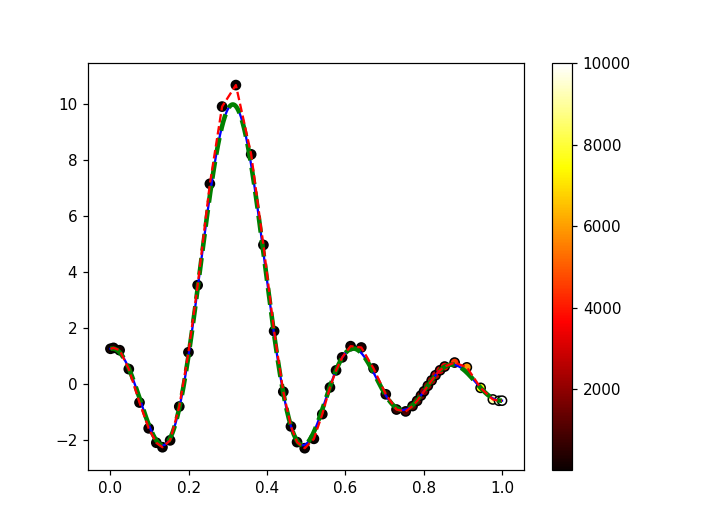

In [23]:
def dist(a,b):
    return np.linalg.norm(a-b)

def knotRemoval(P, W, T, p=degree, tol=1e-3, rational=False):
    if rational:
        tol = (tol*W.min())/(1+np.linalg.norm(P).max())
    m = len(T)-1
    order = p+1
    hispan = m-order
    if hispan<order:
        return P, W, T
    hiu = T[hispan]
    gap = 0
    u = T[order]
    s = order
    while(u==T[s+1]):
        s += 1
    mult = s-p
    fout = (2*s-mult-p)/2
    last = s-mult
    first = mult
    bgap =s
    agap = bgap +1
    PW = toHomogeneous(P, W)
    temp = np.zeros( (2*p+1, PW.shape[1]) )
    while True:
        for t in xrange(mult):
            off = first-1
            temp[0] = PW[off]; 
            temp[last+1-off] = PW[last+1]
            i=first; j=last; ii=first-off; jj=last-off
            remflag = False
            while j-i>t:
                alfi = (u-T[i])/(T[i+order+gap+t]-T[i])
                alfj = (u-T[j-t])/(T[j+order+gap]-T[j-t])
                temp[ii] = (PW[i]-(1.-alfi)*temp[ii-1])/alfi
                temp[jj] = (PW[j]-alfj*temp[jj+1])/(1.-alfj)
                i+=1;ii+=1
                j-=1;jj-=1
            if j-i<t:
                if dist(temp[ii-1],temp[jj+1]) <= tol:
                    remflag = True
            else:
                alfi = (u-T[i])/(T[i+order+gap+t]-T[i])
                if dist(PW[i],alfi*temp[ii+t+1]+(1.-alfi)*temp[ii-1]) <= tol:
                    remflag = True
            if not remflag:
                break
            else:
                i=first; j=last
                while j-i>t:
                    PW[i] = temp[i-off]; PW[j] = temp[j-off]
                    i+=1; j-=1
            first-=1
            last+=1
            
        if t>0:
            j=fout;
            i=j
            for k in xrange(1, t):
                if k%2==1:
                    i+=1
                else:
                    j-=1
            for k in xrange(i+1, bgap+1):
                PW[j] = PW[k]
                j+=1
        else:
            j = bgap+1
        if u==hiu:
            gap += t
            break
        else:
            k1 = s-t+1
            i = k1
            k = s+gap+1
            u = T[k]
            while u==T[k]:
                T[i] = T[k]
                i+=1; k+=1
            mult = i-k1; s=i-1
            gap += t
            for k in xrange(mult):
                PW[j] = PW[agap]
                j+=1; agap+=1
                
            bgap = j-1
            fout = (2*s-p-mult)/2
            last = s-mult; first = s-p
    i = hispan+1;
    k = i-gap    
    for j in xrange(1,order+1):
        T[k] = T[i]
        k+=1; i+=1
    P, W = fromHomogeneous(PW)
    if gap>0: 
        return P[:-gap], W[:-gap], T[:-gap]
    else:
        return P, W, T


popt, Wopt, Topt = knotRemoval(Plocal.copy(), \
                               Wlocal.copy(), \
                               Tnew.copy(), \
                               tol=1e-3, rational=True)
nCtrlPts = len(Topt) - 1 - degree

print "Ctrl points #:", nCtrlPts
E = Error(popt, Wopt, y, U, Topt, degree)
print "Sum of squared error:", np.sum(E**2)
print "Normalized max error:", np.abs(E).max()/yRange

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decode(popt, Wopt, U, Topt, degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(Topt, degree)
plt.plot(coeffs_x, popt, 'r--', label='Control')
plt.scatter(coeffs_x, popt, c=Wopt, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

### Local derivatives

In [18]:
def bezierDer(P, W, U, degree):
    Q = [degree*(P[i+1]-P[i]) for i in xrange(len(P)-1)]
    T = np.concatenate(([0]*degree, [1]*degree))
    U = np.linspace(0,1,U.shape[0])
    return decode(Q, W[:-1], U, T, degree-1)

def pieceBezierDer(P, W, U, T, degree):
    K = range(degree, len(T), degree)
    dCdU = np.zeros_like(y)
    si = 0
    for ki,k in enumerate(K[:-1]):
        span = np.all((U>=T[k], U<=T[K[ki+1]]), axis=0)
        pdC = bezierDer(P[K[ki-1] if ki>0 else 0:k+1], 
                        W[K[ki-1] if ki>0 else 0:k+1], 
                        U[span], 
                        degree)
        dCdU[si:si+len(pdC)] = pdC
#         plt.figure()
#         plt.plot(y[span])
#         plt.plot(pdC)
#         plt.plot(np.gradient(y[span], x[span]))
#         plt.plot(np.zeros_like(pdC), 'k--')
        si += len(pdC)-1
    return dCdU

def pieceBezierDer2(P, W, U, T, degree):
    K = range(degree, len(T), degree)
    bezierP = range(0, len(P)-degree, degree)
    coeffs_x = getControlPoints(np.concatenate(([0]*degree, [1]*degree)), degree-1)
    Q = []
    
    for ps in bezierP:
        pp = P[ps:ps+degree+1]
        qq = np.asarray([degree*(pp[i+1]-pp[i]) for i in xrange(len(pp)-1)])
        for qi,qval in enumerate(qq):
            if qi == 0 and ps>0:
                qq += (Q[-1]-qval)
                continue
            Q.append(qval)
    return Q, np.ones_like(Q), np.delete(T, K)


dd = pieceBezierDer(Plocal, Wlocal, U, T, degree)
plt.figure()
plt.plot(y)
plt.plot(dd)
plt.plot(np.gradient(y, x))
plt.plot(np.zeros_like(y), 'k--')

pder, Wder, Tder = pieceBezierDer2(Plocal, Wlocal, U, T, degree)
plt.figure()
plt.plot(U, y)
plt.plot(U, decode(pder, Wder, U, Tder, degree-1))
plt.plot(U, np.gradient(y, x))
plt.plot(U, np.zeros_like(y), 'k--')

# print Plocal
# plt.figure()
# plt.plot(U, y, 'b-', ms=5, label='Input')
# plt.plot(U, decode(Plocal, Wlocal, U, T, degree), 'g--', lw=3, label='Decoded')
# plt.plot(U, pieceBezierDer(Plocal, Wlocal, U, T, degree)/yRange, 'r--', label='1st Derivative')

ValueError: operands could not be broadcast together with shapes (4,) (0,) 

In [ ]:
def bezierDer(P, W, U, degree):
    Q = [degree*(P[i+1]-P[i]) for i in xrange(len(P)-1)]
    T = np.concatenate(([0]*degree, [1]*degree))
    U = np.linspace(0,1,U.shape[0])
    return decode(Q, W[:-1], U, T, degree-1)

def pieceBezierDer(P, W, U, T, degree):
    K = range(degree, len(T), degree)
    dCdU = np.zeros_like(y)
    si = 0
    for ki,k in enumerate(K[:-1]):
        span = np.all((U>=T[k], U<=T[K[ki+1]]), axis=0)
        pdC = bezierDer(P[K[ki-1] if ki>0 else 0:k+1], 
                        W[K[ki-1] if ki>0 else 0:k+1], 
                        U[span], 
                        degree)
        dCdU[si:si+len(pdC)] = pdC
#         plt.figure()
#         plt.plot(y[span])
#         plt.plot(pdC)
#         plt.plot(np.gradient(y[span], x[span]))
#         plt.plot(np.zeros_like(pdC), 'k--')
        si += len(pdC)-1
    return dCdU

def pieceBezierDer2(P, W, U, T, degree):
    K = range(degree, len(T), degree)
    bezierP = range(0, len(P)-degree, degree)
    coeffs_x = getControlPoints(np.concatenate(([0]*degree, [1]*degree)), degree-1)
    Q = []
    
    for ps in bezierP:
        pp = P[ps:ps+degree+1]
        qq = np.asarray([degree*(pp[i+1]-pp[i]) for i in xrange(len(pp)-1)])
        for qi,qval in enumerate(qq):
            if qi == 0 and ps>0:
                qq += (Q[-1]-qval)
                continue
            Q.append(qval)
    return Q, np.ones_like(Q), np.delete(T, K)


dd = pieceBezierDer(Plocal, Wlocal, U, T, degree)
plt.figure()
plt.plot(y)
plt.plot(dd)
plt.plot(np.gradient(y, x))
plt.plot(np.zeros_like(y), 'k--')

pder, Wder, Tder = pieceBezierDer2(Plocal, Wlocal, U, T, degree)
plt.figure()
plt.plot(U, y)
plt.plot(U, decode(pder, Wder, U, Tder, degree-1))
plt.plot(U, np.gradient(y, x))
plt.plot(U, np.zeros_like(y), 'k--')

# print Plocal
# plt.figure()
# plt.plot(U, y, 'b-', ms=5, label='Input')
# plt.plot(U, decode(Plocal, Wlocal, U, T, degree), 'g--', lw=3, label='Decoded')
# plt.plot(U, pieceBezierDer(Plocal, Wlocal, U, T, degree)/yRange, 'r--', label='1st Derivative')



## Scratch space

Ctrl Points: 6
Relative Max Error: 0.4673467362071179


<IPython.core.display.Javascript object>


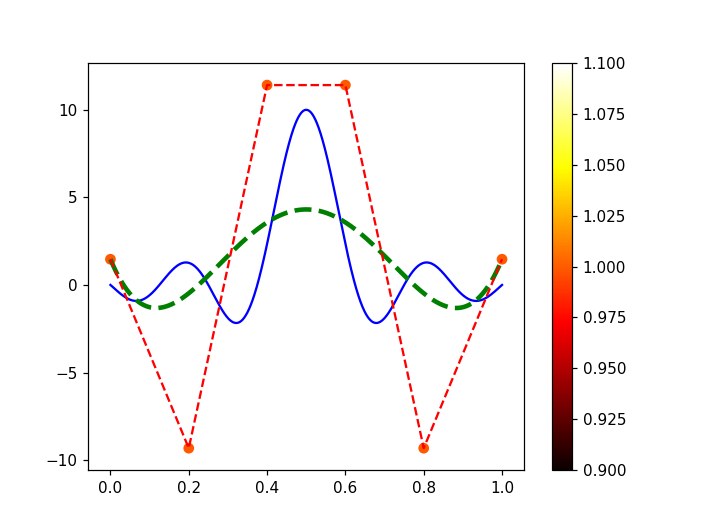

Iteration  0
Ctrl Points: 7
Max Error is at span: 5 (1,6)
Local solving (0,7)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 222.271942
  Number of iterations: 101
  Number of functions evaluations: 161


<IPython.core.display.Javascript object>


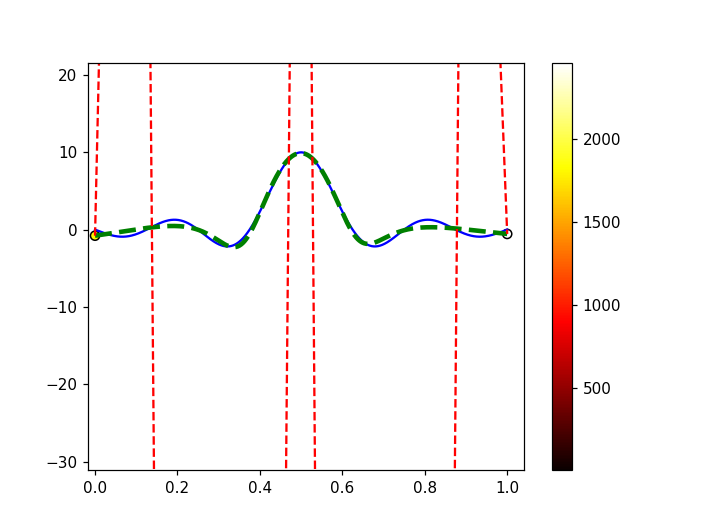

Normalized max error: 0.08009861127806206
Iteration  0
Ctrl Points: 8
Max Error is at span: 6 (2,7)
Local solving (0,8)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 115.225204
  Number of iterations: 101
  Number of functions evaluations: 145


<IPython.core.display.Javascript object>


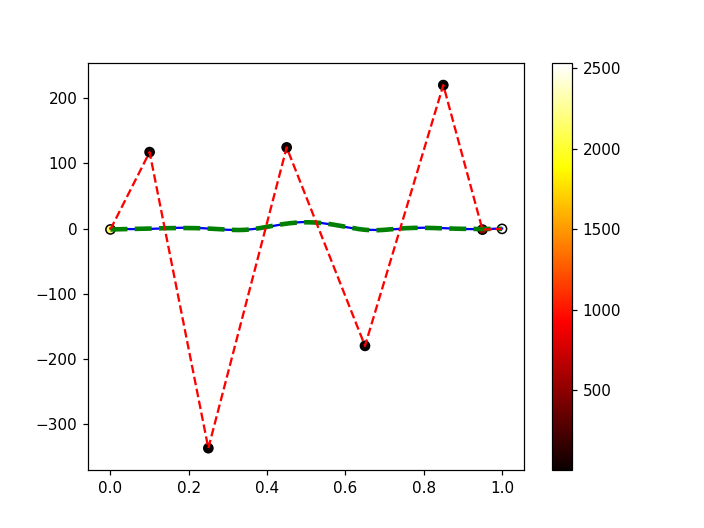

Normalized max error: 0.11113487638869253
Iteration  0
Ctrl Points: 9
Max Error is at span: 5 (1,6)
Local solving (0,9)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 15.313388
  Number of iterations: 101
  Number of functions evaluations: 142


<IPython.core.display.Javascript object>


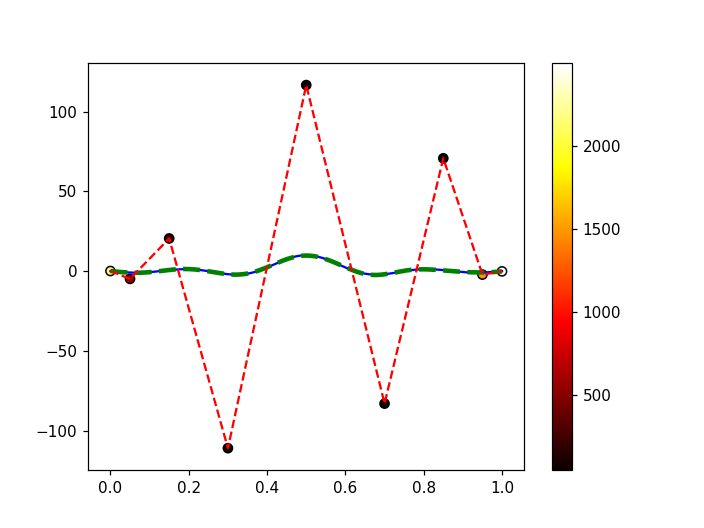

Normalized max error: 0.022491290407830742
Iteration  0
Ctrl Points: 10
Max Error is at span: 7 (3,8)
Local solving (0,10)
Constrains (0,0)
INFO:tensorflow:Optimization terminated with:
  Message: Iteration limit exceeded
  Objective function value: 0.578478
  Number of iterations: 101
  Number of functions evaluations: 130


<IPython.core.display.Javascript object>


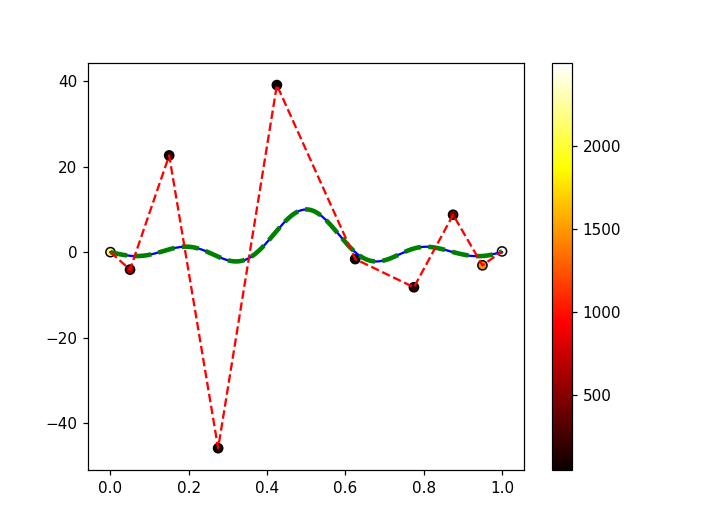

Normalized max error: 0.015184999752815394
Iteration  0
Ctrl Points: 11
Max Error is at span: 9 (5,10)
Local solving (0,11)
Constrains (5,0)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 0.128083
  Number of iterations: 52
  Number of functions evaluations: 63


<IPython.core.display.Javascript object>


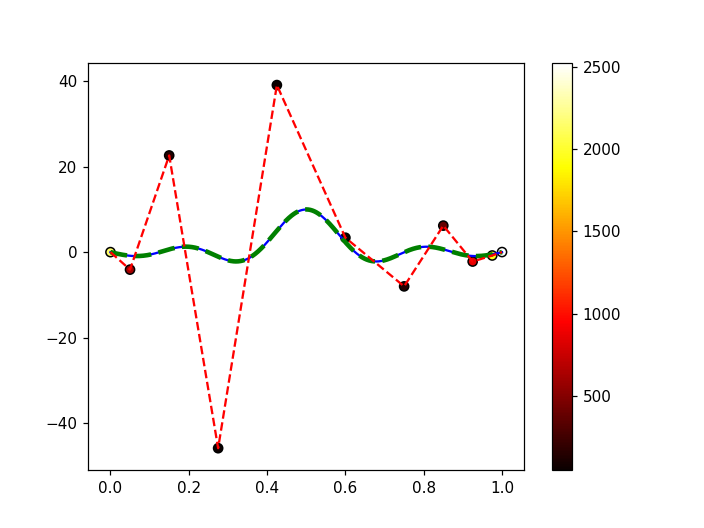

Normalized max error: 0.002510861889790492
Iteration  0
Ctrl Points: 12
Max Error is at span: 10 (6,11)
Local solving (1,12)
Constrains (5,0)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 54.165321
  Number of iterations: 10
  Number of functions evaluations: 21


<IPython.core.display.Javascript object>


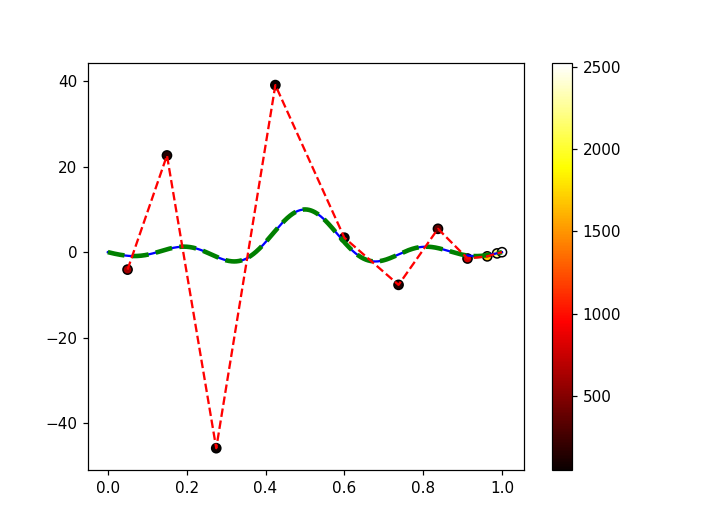

Normalized max error: 0.0022400569039810877
Iteration  0
Ctrl Points: 13
Max Error is at span: 6 (2,7)
Local solving (0,12)
Constrains (0,5)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 0.156926
  Number of iterations: 52
  Number of functions evaluations: 63


<IPython.core.display.Javascript object>


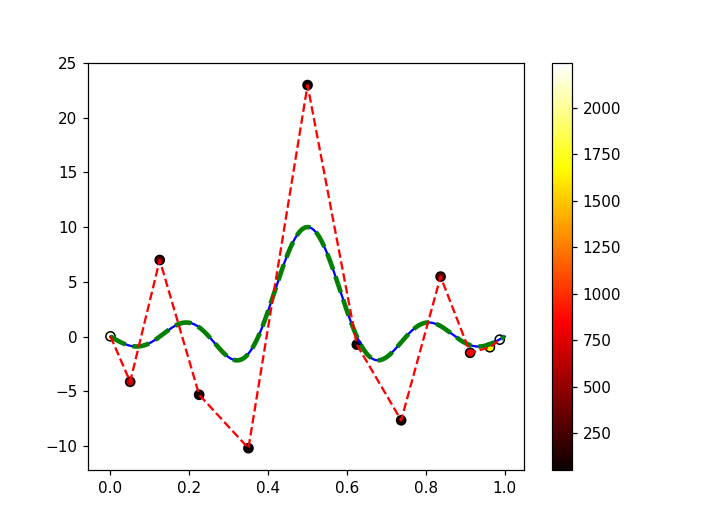

Normalized max error: 0.0016963978345754735
Iteration  0
Ctrl Points: 14
Max Error is at span: 5 (1,6)
Local solving (0,11)
Constrains (0,5)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 4.140792
  Number of iterations: 1
  Number of functions evaluations: 4


<IPython.core.display.Javascript object>


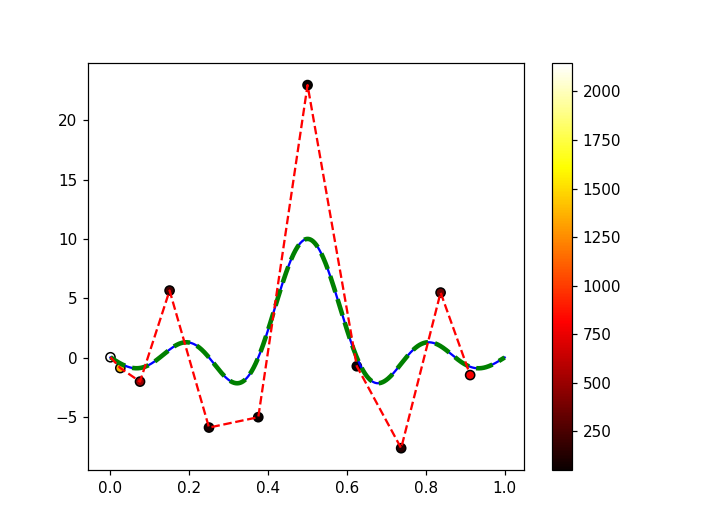

Normalized max error: 0.0017022818461678532
Iteration  0
Ctrl Points: 15
Max Error is at span: 5 (1,6)
Local solving (0,11)
Constrains (0,5)
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 160.210098
  Number of iterations: 8
  Number of functions evaluations: 30


<IPython.core.display.Javascript object>


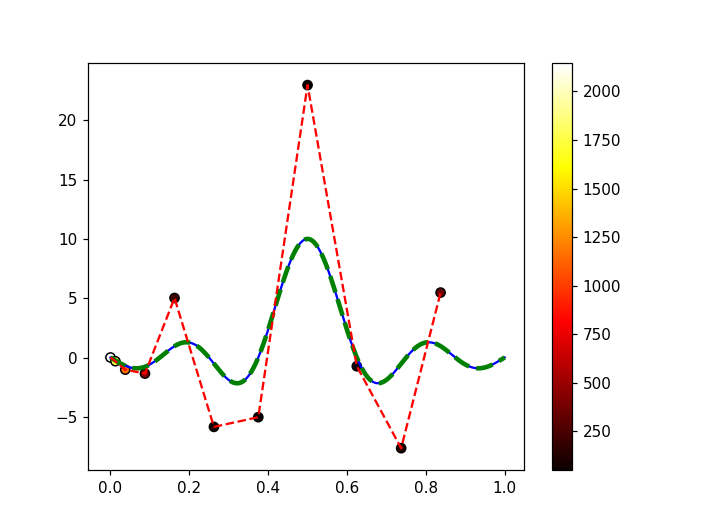

Normalized max error: 0.0005950528696932551
Ctrl points #: 15
Sum of squared error: 0.01157450142101152
Normalized max error: 0.0005950528696932551
fevals: 759
[2143.80151367 1758.20825195 1152.98901367  450.98455811  217.64555359
   89.94177246   55.96683884   52.28207397   67.02014923  141.07052612
  359.47589111  788.88238525 1684.0045166  2238.22021484 2520.68164062]


<IPython.core.display.Javascript object>


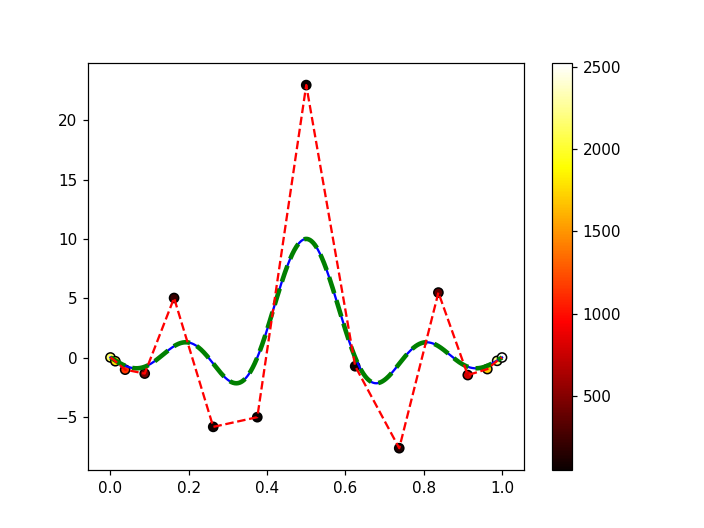

In [126]:
#%matplotlib inline

T  = knots.copy()
N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
W0 = np.ones(nControlPoints)
PH = lsqFit(N, W0, y, U, knots, degree)
errorsHPD = []

optParams = {'P':PH, 'N':N, 'T':T, 'y':y, 'U':U, 'degree':degree, 'EList':errorsHPD}
# W0,_ = XieOptW(W0, optParams, optimizer='L-BFGS-B', der=dE_dW, bnds=wbounds)
# PH   = optParams['P']

totalFitE = NMaxError(PH, W0, y, U, T)
print "Ctrl Points:", nControlPoints
print "Relative Max Error:", totalFitE
plt.figure()
plt.plot(optParams['U'], optParams['y'], 'b-', ms=5, label='Input')
plt.plot(optParams['U'], decode(optParams['P'], W0, optParams['U'], optParams['T'], degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(optParams['T'], degree)
plt.plot(coeffs_x, optParams['P'], 'r--', label='Control')
plt.scatter(coeffs_x, optParams['P'], c=W0, cmap='hot')
plt.colorbar()
        
RMAX_ERR = 1.668101e-03
C = degree

while totalFitE > RMAX_ERR:
    PH, W0, T, ks = adaptive(PH, W0, T, MAX_ERR=RMAX_ERR, strategy='extend', MAX_ITER=1, split_all=False, r=1)
    print "Ctrl Points:", len(PH)
    for k in ks:
        addedPs = k-degree+1
        addedPe = k+1
        print "Max Error is at span:", k, "(%d,%d)"%(addedPs, addedPe)

        ps = max(addedPs-C,0)
        pe = min(addedPe+C,len(PH))
        print "Local solving (%d,%d)"%(ps,pe)

        CLeft  = 0 if addedPs<C else C
        CRight = 0 if pe-addedPe<C else C
        print "Constrains (%d,%d)"%(CLeft,CRight)
        
        t = T[ps:pe+degree+1]
        coeffs_x = getControlPoints(t, degree)
        optParams['T'] = t
        optParams['U'] = U[np.all((U>=coeffs_x[0], U<=coeffs_x[-1]), axis=0)]
        optParams['y'] = y[np.all((U>=coeffs_x[0], U<=coeffs_x[-1]), axis=0)]
        optParams['N'] = basis(optParams['U'][np.newaxis,:],degree,t[:,np.newaxis]).T
        optParams['P'] = PH[ps:pe]
        ww             = W0[ps:pe]
        wbounds        = [(1,1e4) for _ in ww]
        cons           = [PH,W0]
        NP             = len(ww)
        W0[ps:pe],_    = ADOptW(ww, optParams,  optimizer='SLSQP', bnds=wbounds,
                                 constraintRanges=[[(0,CLeft),(ps,ps+CLeft)],
                                                   [(NP-CRight,NP),(pe-CRight,pe)]],
                                 constraints=cons)
        PH[ps:pe]   = optParams['P']
#         pp = lsqFit(optParams['N'], ww, 
#                     optParams['y'], optParams['U'], 
#                     optParams['T'], optParams['degree'],
#                     constraints = cons )
#         PH[ps:pe]   = pp

        plt.figure()
        plt.plot(U, y, 'b-', ms=5, label='Input')
        plt.plot(U, decode(PH, W0, U, T, degree), 'g--', lw=3, label='Decoded')
        coeffs_x = getControlPoints(optParams['T'], degree)
        plt.plot(coeffs_x, optParams['P'], 'r--', label='Control')
        plt.scatter(coeffs_x, optParams['P'], c=ww, edgecolor=(0,0,0,1), cmap='hot')
        plt.colorbar()

    totalFitE = NMaxError(PH, W0, y, U, T)
    print "Normalized max error:", totalFitE

print "Ctrl points #:", len(W0)
E = Error(PH, W0, y, U, T, degree)
print "Sum of squared error:", np.sum(E**2)
print "Normalized max error:", np.abs(E).max()/yRange
print "fevals:", len(errorsHPD)
print W0

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decode(PH, W0, U, T, degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(T, degree)
plt.plot(coeffs_x, PH, 'r--', label='Control')
plt.scatter(coeffs_x, PH, c=W0, edgecolor=(0,0,0,1), cmap='hot')
plt.colorbar()

In [10]:
T  = knots.copy()
N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
W0 = np.ones(nControlPoints)
PH = lsqFit(N, W0, y, U, knots, degree)
errorsHPD = []
optParams = {'P':PH, 'N':N, 'T':T, 'y':y, 'U':U, 'degree':degree,'EList':errorsHPD}
W0,_ = XieOptW(W0, optParams, optimizer='BFGS', der=dE_dW)
PH = optParams['P']

print NMaxError(PH, W0, y, U, T)
plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decode(PH, W0, U, T, degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(T, degree)
plt.plot(coeffs_x, PH, 'r--', label='Control')
plt.scatter(coeffs_x, PH, c=W0, cmap='hot')
plt.colorbar()


ps = nControlPoints/2 - degree-1
pe = ps+2*degree+1


t = T[ps:pe+degree+1]
coeffs_x = getControlPoints(t, degree)
optParams['T'] = t
optParams['U'] = U[np.all((U>coeffs_x[0], U<coeffs_x[-1]), axis=0)]
optParams['y'] = y[np.all((U>coeffs_x[0], U<coeffs_x[-1]), axis=0)]
optParams['N'] = basis(optParams['U'][np.newaxis,:],degree,t[:,np.newaxis]).T
optParams['P'] = PH[ps:pe]
optParams['degree'] = degree
ww             = W0[ps:pe]
wbounds        = [(1e-4,1e4) for _ in ww]

print "P Subset (%d,%d)"%(ps,pe), PH[ps:pe], len(PH[ps:pe])

continuity = degree-1
C = continuity+1
cons = []
cons.append({'type': 'eq', 'fun' : lambda x: x[:C]-PH[ps:ps+C] })
cons.append({'type': 'eq', 'fun' : lambda x: x[-C:]-PH[pe-C:pe] })

#W0[ps:pe],_ = XieOptW(ww, optParams, optimizer='L-BFGS-B', der=dE_dW, bnds=wbounds)
pp = lsqFit(optParams['N'], ww, 
            optParams['y'], optParams['U'], 
            optParams['T'], optParams['degree'],
            constraints = cons )
print "endpoints", PH[ps:ps+C], pp[:C]
print "endpoints", PH[pe-C:pe], pp[-C:]
PH[ps:pe]   = pp#optParams['P']
print "P Subset after solve", PH[ps:pe]

print NMaxError(PH, W0, y, U, T)

plt.figure()
plt.plot(optParams['U'], optParams['y'], 'b-', ms=5, label='Input')
plt.plot(optParams['U'], decode(optParams['P'], ww, optParams['U'], optParams['T'], degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(optParams['T'], degree)
plt.plot(coeffs_x, optParams['P'], 'r--', label='Control')
plt.scatter(coeffs_x, optParams['P'], c=ww, cmap='hot')
plt.colorbar()

plt.figure()
plt.plot(U, y, 'b-', ms=5, label='Input')
plt.plot(U, decode(PH, W0, U, T, degree), 'g--', lw=3, label='Decoded')
coeffs_x = getControlPoints(T, degree)
plt.plot(coeffs_x, PH, 'r--', label='Control')
plt.scatter(coeffs_x, PH, c=W0, cmap='hot')
plt.colorbar()

print W0

0.1282472669678658


<IPython.core.display.Javascript object>

ValueError: negative dimensions are not allowed

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

RMAX_ERR = 1e-2

# while(NMaxError(PH, W0, T)>RMAX_ERR):
#     W0,fev = optW(PH, W0, optimizer='BFGS', der=dE_dW, bnds=wbounds)
#     PH, W0, T = adaptive(PH, W0, T, MAX_ERR=RMAX_ERR, strategy='reset', MAX_ITER=1, split_all=True)
#     N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T

PH = popt.copy()
W0 = np.ones_like(PH)
T  = knots.copy()
N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
errorsHPD = [SSE(W0, PH, T, y, U)]

lines = []
fig, ax = plt.subplots()
lines.append(ax.plot(x, y, 'b-', ms=5, label='Input')[0])
lines.append(ax.plot(x, decode(PH, W0, x, T* (Dmax - Dmin) + Dmin, degree), 'g--', lw=3, label='Decoded')[0])
coeffs_x = getControlPoints(T, degree) * (Dmax - Dmin) + Dmin
lines.append(ax.plot(coeffs_x, PH, 'r--', label='Control')[0])
lines.append(ax.scatter(coeffs_x, PH, c='r', s=50*(W0/W0.max()), alpha=0.5))

def adaptSolve():
    global  PH, W0, T, N
    while NMaxError(PH, W0, y, U, T)>RMAX_ERR:
        PH, W0, T, k = adaptive(PH, W0, T, MAX_ERR=RMAX_ERR, strategy='reset', MAX_ITER=1, split_all=True)
        N = basis(U[np.newaxis,:],degree,T[:,np.newaxis]).T
        optParams = {'P':PH, 'N':N, 'T':T, 'y':y, 'U':U, 'EList':errorsHPD}
        wbounds        = [(1,1e4) for _ in W0]
        W0,_ = XieOptW(W0, optParams, optimizer='L-BFGS-B', der=dE_dW, bnds=wbounds)
        PH = optParams['P']
        yield PH, W0, T
        
# animation function. This is called sequentially
def update(parms):
    P, W, T = parms[0], parms[1], parms[2]
    coeffs_x = getControlPoints(T, degree) * (Dmax - Dmin) + Dmin
    
    lines[1].set_data(x, decode(P, W, x, T* (Dmax - Dmin) + Dmin, degree))
    lines[2].set_data(coeffs_x, P)
    lines[3].set_offsets(np.array([coeffs_x, P]).T)
    w = W-W.min()
    lines[3].set_sizes(50*(w/w.max()))
    return lines

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, update, repeat=True, blit=True, frames=adaptSolve, interval=500)
plt.legend()
plt.show()

HTML(anim.to_html5_video())

### Export plots to EPS

<IPython.core.display.Javascript object>


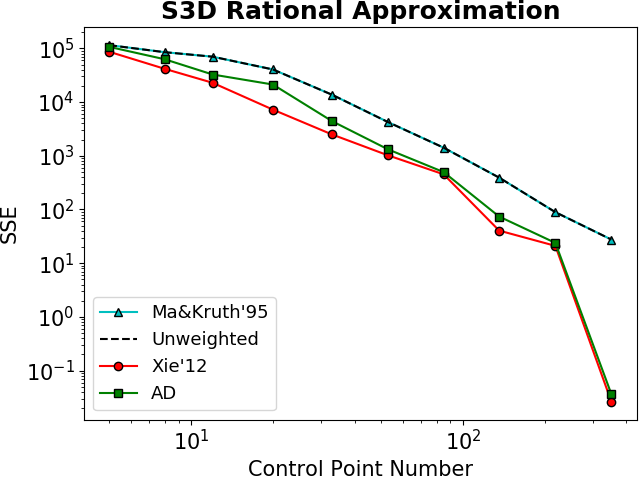

In [38]:
import os

os.chdir("/home/ynashed/Dropbox/ANL/Papers/ICCS_2019/results")
maxErrors = np.genfromtxt(("sinc" if sincFunc else "s3d")+("_%i_SSEvsN_deg%i.csv"%(nPoints,degree)), 
                          delimiter=',')
nControl_min = degree + 1
nControl_max = nPoints/2
numRuns = 10
xAxis = np.geomspace(nControl_min, nControl_max, num=numRuns, dtype=int)
#plt.figure(figsize=(5.25,5.3))
plt.figure()
plt.rcParams.update({'font.size': 15})
plt.axes().set_aspect (aspect='auto')
plt.plot(xAxis, maxErrors[:,3], 'c^-', label='Ma&Kruth\'95', mec=(0,0,0,1))
plt.plot(xAxis, maxErrors[:,0], 'k--', label='Unweighted')
plt.plot(xAxis, maxErrors[:,1], 'ro-', label='Xie\'12', mec=(0,0,0,1))
plt.plot(xAxis, maxErrors[:,2], 'gs-', label='AD', mec=(0,0,0,1))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('SSE')
plt.xlabel('Control Point Number')
plt.title(("Sinc" if sincFunc else "S3D")+' Rational Approximation', fontweight='bold')
plt.legend(fontsize=13, loc='lower left')
plt.tight_layout(pad=0)

plt.savefig(("sinc" if sincFunc else "s3d")+("_%i_SSEvsN_deg%i.eps"%(nPoints,degree)), format='eps', dpi=1000)

<IPython.core.display.Javascript object>


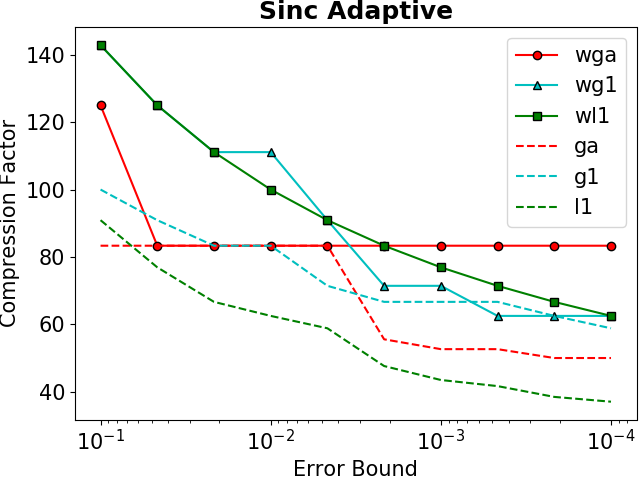

<IPython.core.display.Javascript object>


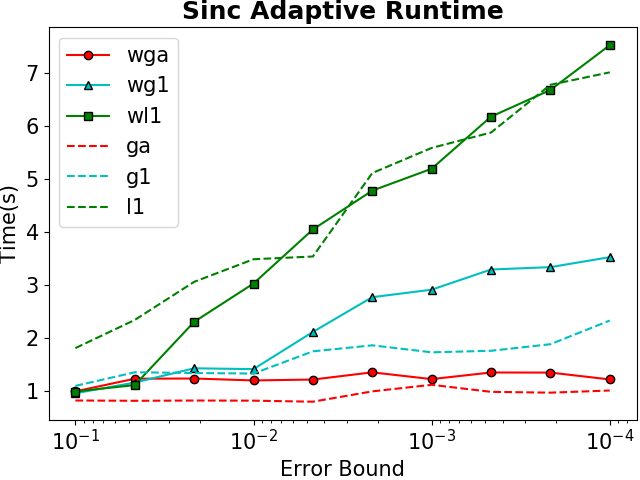

In [67]:
compressionFactors = np.genfromtxt(("sinc" if sincFunc else "s3d")+("_%i_nCtrlvsEps_deg%i.csv"%(nPoints,degree) ), delimiter=',')
cost = np.genfromtxt(("sinc" if sincFunc else "s3d")+("_%i_cost_deg%i.csv"%(nPoints,degree) ), delimiter=',')
epsilon_max = 1e-1
epsilon_min = 1e-4
xAxis = np.geomspace(epsilon_max, epsilon_min, numRuns)


plt.figure()#figsize=(5.25,5.3))
plt.plot(xAxis, compressionFactors[:,0], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,1], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,3], 'r--', label='ga', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,4], 'c--', label='g1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,5], 'g--', label='l1', mec=(0,0,0,1))
#plt.yscale('log')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.ylabel('Compression Factor')
plt.xlabel('Error Bound')
plt.title(("Sinc" if sincFunc else "S3D")+' Adaptive', fontweight='bold')
plt.tight_layout(pad=0)
plt.legend()
plt.savefig(("sinc" if sincFunc else "s3d")+("_%i_nCtrlvsEps_deg%i.eps"%(nPoints,degree) ), format='eps', dpi=1000)

plt.figure()#figsize=(5.25,5.3))
plt.plot(xAxis, cost[:,0], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,1], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,3], 'r--', label='ga', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,4], 'c--', label='g1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,5], 'g--', label='l1', mec=(0,0,0,1))
#plt.yscale('log')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.ylabel('Time(s)')
plt.xlabel('Error Bound')
plt.title(("Sinc" if sincFunc else "S3D")+' Adaptive Runtime', fontweight='bold')
plt.tight_layout(pad=0)
plt.legend()
plt.savefig(("sinc" if sincFunc else "s3d")+("_%i_cost_deg%i.eps"%(nPoints,degree) ), format='eps', dpi=1000)

<IPython.core.display.Javascript object>


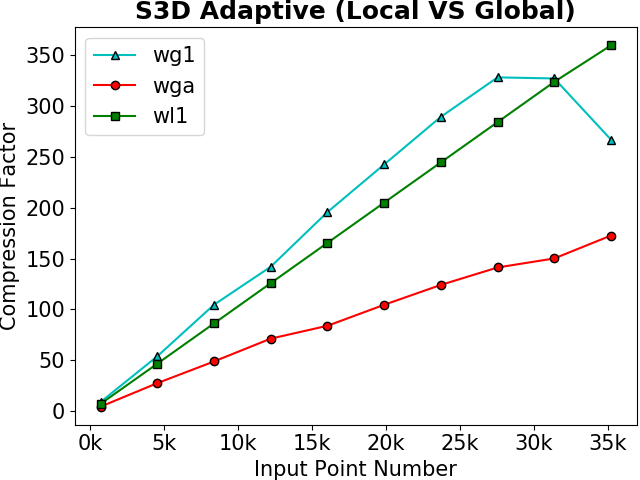

<IPython.core.display.Javascript object>


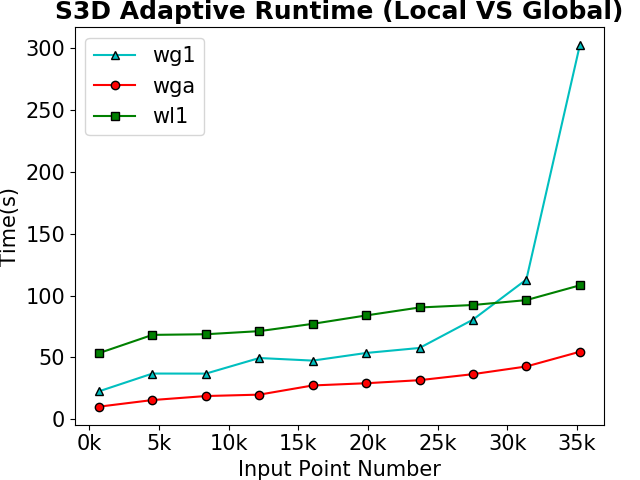

In [63]:
from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

compressionFactors = np.genfromtxt(("sinc" if sincFunc else "s3d")+("_%i_nCtrlvsScale_deg%i.csv"%(nPoints,degree)), delimiter=',')
cost = np.genfromtxt(("sinc" if sincFunc else "s3d")+("_%i_costvsScale_deg%i.csv"%(nPoints,degree)), delimiter=',')
numRuns = 10
xAxis = np.linspace(1, 50, numRuns) * nPoints

plt.figure()#figsize=(5.25,5.3))
plt.plot(xAxis, compressionFactors[:,0], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,1], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, compressionFactors[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.ylabel('Compression Factor')
plt.xlabel('Input Point Number')
plt.axes().xaxis.set_major_formatter(formatter)
plt.title(("Sinc" if sincFunc else "S3D")+' Adaptive (Local VS Global)', fontweight='bold')
plt.tight_layout(pad=0)
plt.legend()
plt.savefig(("sinc" if sincFunc else "s3d")+("_%i_nCtrlvsScale_deg%i.eps"%(nPoints,degree)), format='eps', dpi=1000)

plt.figure()#figsize=(5.25,5.3))
plt.plot(xAxis, cost[:,0], 'c^-', label='wg1', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,1], 'ro-', label='wga', mec=(0,0,0,1))
plt.plot(xAxis, cost[:,2], 'gs-', label='wl1', mec=(0,0,0,1))
plt.ylabel('Time(s)')
plt.xlabel('Input Point Number')
plt.axes().xaxis.set_major_formatter(formatter)
plt.title(("Sinc" if sincFunc else "S3D")+' Adaptive Runtime (Local VS Global)', fontweight='bold')
plt.tight_layout(pad=0)
plt.legend()
plt.savefig(("sinc" if sincFunc else "s3d")+("_%i_costvsScale_deg%i.eps"%(nPoints,degree)), format='eps', dpi=1000)

In [68]:
!mv *.eps ../figs/